In [ ]:
pip install gluonts

     |████████████████████████████████| 2.1 MB 5.0 MB/s 
     |████████████████████████████████| 10.1 MB 16.5 MB/s 
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 3.7.4.3
    Uninstalling typing-extensions-3.7.4.3:
      Successfully uninstalled typing-extensions-3.7.4.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.6.0 requires typing-extensions~=3.7.4, but you have typing-extensions 3.10.0.0 which is incompatible.


In [ ]:
import warnings
from math import sqrt
import lightgbm as lgb
import matplotlib as mpl
import numpy as np
import pandas as pd  # Basic library for all of our dataset operations
import pmdarima as pm
import shap
import statsmodels as sm
import tensorflow as tf
import xgboost as xgb
from bayes_opt import BayesianOptimization
from fbprophet import Prophet
from gluonts.dataset.common import ListDataset
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.model.deepar import DeepAREstimator
from gluonts.mx.trainer import Trainer
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn import linear_model, svm
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa import api as smt
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm

#from utils import evaluate
#from utils import bar_metrics


# We will use deprecated models of statmodels which throw a lot of warnings to use more modern ones
warnings.filterwarnings("ignore")


# Extra settings
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
plt.style.use('bmh')
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['text.color'] = 'k'
print(tf.__version__)

/usr/local/lib/python3.7/dist-packages/gluonts/json.py:46: UserWarning:

Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.



2.6.0


In [ ]:
import numpy as np
from sklearn.metrics import r2_score

EPSILON = 1e-10


def _error(actual: np.ndarray, predicted: np.ndarray):
    """Simple error"""
    return actual - predicted


def _percentage_error(actual: np.ndarray, predicted: np.ndarray):
    """
    Percentage error

    Note: result is NOT multiplied by 100
    """
    return _error(actual, predicted) / (actual + EPSILON)


def _naive_forecasting(actual: np.ndarray, seasonality: int = 1):
    """Naive forecasting method which just repeats previous samples"""
    return actual[:-seasonality]


def _relative_error(
    actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None
):
    """Relative Error"""
    if benchmark is None or isinstance(benchmark, int):
        # If no benchmark prediction provided - use naive forecasting
        if not isinstance(benchmark, int):
            seasonality = 1
        else:
            seasonality = benchmark
        return _error(actual[seasonality:], predicted[seasonality:]) / (
            _error(actual[seasonality:], _naive_forecasting(actual, seasonality))
            + EPSILON
        )

    return _error(actual, predicted) / (_error(actual, benchmark) + EPSILON)


def _bounded_relative_error(
    actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None
):
    """Bounded Relative Error"""
    if benchmark is None or isinstance(benchmark, int):
        # If no benchmark prediction provided - use naive forecasting
        if not isinstance(benchmark, int):
            seasonality = 1
        else:
            seasonality = benchmark

        abs_err = np.abs(_error(actual[seasonality:], predicted[seasonality:]))
        abs_err_bench = np.abs(
            _error(actual[seasonality:], _naive_forecasting(actual, seasonality))
        )
    else:
        abs_err = np.abs(_error(actual, predicted))
        abs_err_bench = np.abs(_error(actual, benchmark))

    return abs_err / (abs_err + abs_err_bench + EPSILON)


def _geometric_mean(a, axis=0, dtype=None):
    """Geometric mean"""
    if not isinstance(a, np.ndarray):  # if not an ndarray object attempt to convert it
        log_a = np.log(np.array(a, dtype=dtype))
    elif dtype:  # Must change the default dtype allowing array type
        if isinstance(a, np.ma.MaskedArray):
            log_a = np.log(np.ma.asarray(a, dtype=dtype))
        else:
            log_a = np.log(np.asarray(a, dtype=dtype))
    else:
        log_a = np.log(a)
    return np.exp(log_a.mean(axis=axis))


def mse(actual: np.ndarray, predicted: np.ndarray):
    """Mean Squared Error"""
    return np.mean(np.square(_error(actual, predicted)))


def rmse(actual: np.ndarray, predicted: np.ndarray):
    """Root Mean Squared Error"""
    return np.sqrt(mse(actual, predicted))


def nrmse(actual: np.ndarray, predicted: np.ndarray):
    """Normalized Root Mean Squared Error"""
    return rmse(actual, predicted) / (actual.max() - actual.min())


def me(actual: np.ndarray, predicted: np.ndarray):
    """Mean Error"""
    return np.mean(_error(actual, predicted))


def mae(actual: np.ndarray, predicted: np.ndarray):
    """Mean Absolute Error"""
    return np.mean(np.abs(_error(actual, predicted)))


mad = mae  # Mean Absolute Deviation (it is the same as MAE)


def gmae(actual: np.ndarray, predicted: np.ndarray):
    """Geometric Mean Absolute Error"""
    return _geometric_mean(np.abs(_error(actual, predicted)))


def mdae(actual: np.ndarray, predicted: np.ndarray):
    """Median Absolute Error"""
    return np.median(np.abs(_error(actual, predicted)))


def mpe(actual: np.ndarray, predicted: np.ndarray):
    """Mean Percentage Error"""
    return np.mean(_percentage_error(actual, predicted))


def mape(actual: np.ndarray, predicted: np.ndarray):
    """
    Mean Absolute Percentage Error

    Properties:
        + Easy to interpret
        + Scale independent
        - Biased, not symmetric
        - Undefined when actual[t] == 0

    Note: result is NOT multiplied by 100
    """
    return np.mean(np.abs(_percentage_error(actual, predicted)))


def mdape(actual: np.ndarray, predicted: np.ndarray):
    """
    Median Absolute Percentage Error

    Note: result is NOT multiplied by 100
    """
    return np.median(np.abs(_percentage_error(actual, predicted)))


def smape(actual: np.ndarray, predicted: np.ndarray):
    """
    Symmetric Mean Absolute Percentage Error

    Note: result is NOT multiplied by 100
    """
    return np.mean(
        2.0
        * np.abs(actual - predicted)
        / ((np.abs(actual) + np.abs(predicted)) + EPSILON)
    )


def smdape(actual: np.ndarray, predicted: np.ndarray):
    """
    Symmetric Median Absolute Percentage Error

    Note: result is NOT multiplied by 100
    """
    return np.median(
        2.0
        * np.abs(actual - predicted)
        / ((np.abs(actual) + np.abs(predicted)) + EPSILON)
    )


def maape(actual: np.ndarray, predicted: np.ndarray):
    """
    Mean Arctangent Absolute Percentage Error

    Note: result is NOT multiplied by 100
    """
    return np.mean(np.arctan(np.abs((actual - predicted) / (actual + EPSILON))))


def mase(actual: np.ndarray, predicted: np.ndarray, seasonality: int = 1):
    """
    Mean Absolute Scaled Error

    Baseline (benchmark) is computed with naive forecasting (shifted by @seasonality)
    """
    return mae(actual, predicted) / mae(
        actual[seasonality:], _naive_forecasting(actual, seasonality)
    )


def std_ae(actual: np.ndarray, predicted: np.ndarray):
    """Normalized Absolute Error"""
    __mae = mae(actual, predicted)
    return np.sqrt(
        np.sum(np.square(_error(actual, predicted) - __mae)) / (len(actual) - 1)
    )


def std_ape(actual: np.ndarray, predicted: np.ndarray):
    """Normalized Absolute Percentage Error"""
    __mape = mape(actual, predicted)
    return np.sqrt(
        np.sum(np.square(_percentage_error(actual, predicted) - __mape))
        / (len(actual) - 1)
    )


def rmspe(actual: np.ndarray, predicted: np.ndarray):
    """
    Root Mean Squared Percentage Error

    Note: result is NOT multiplied by 100
    """
    return np.sqrt(np.mean(np.square(_percentage_error(actual, predicted))))


def rmdspe(actual: np.ndarray, predicted: np.ndarray):
    """
    Root Median Squared Percentage Error

    Note: result is NOT multiplied by 100
    """
    return np.sqrt(np.median(np.square(_percentage_error(actual, predicted))))


def rmsse(actual: np.ndarray, predicted: np.ndarray, seasonality: int = 1):
    """Root Mean Squared Scaled Error"""
    q = np.abs(_error(actual, predicted)) / mae(
        actual[seasonality:], _naive_forecasting(actual, seasonality)
    )
    return np.sqrt(np.mean(np.square(q)))


def inrse(actual: np.ndarray, predicted: np.ndarray):
    """Integral Normalized Root Squared Error"""
    return np.sqrt(
        np.sum(np.square(_error(actual, predicted)))
        / np.sum(np.square(actual - np.mean(actual)))
    )


def rrse(actual: np.ndarray, predicted: np.ndarray):
    """Root Relative Squared Error"""
    return np.sqrt(
        np.sum(np.square(actual - predicted))
        / np.sum(np.square(actual - np.mean(actual)))
    )


def mre(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None):
    """Mean Relative Error"""
    return np.mean(_relative_error(actual, predicted, benchmark))


def rae(actual: np.ndarray, predicted: np.ndarray):
    """Relative Absolute Error (aka Approximation Error)"""
    return np.sum(np.abs(actual - predicted)) / (
        np.sum(np.abs(actual - np.mean(actual))) + EPSILON
    )


def mrae(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None):
    """Mean Relative Absolute Error"""
    return np.mean(np.abs(_relative_error(actual, predicted, benchmark)))


def mdrae(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None):
    """Median Relative Absolute Error"""
    return np.median(np.abs(_relative_error(actual, predicted, benchmark)))


def gmrae(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None):
    """Geometric Mean Relative Absolute Error"""
    return _geometric_mean(np.abs(_relative_error(actual, predicted, benchmark)))


def mbrae(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None):
    """Mean Bounded Relative Absolute Error"""
    return np.mean(_bounded_relative_error(actual, predicted, benchmark))


def umbrae(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None):
    """Unscaled Mean Bounded Relative Absolute Error"""
    __mbrae = mbrae(actual, predicted, benchmark)
    return __mbrae / (1 - __mbrae)


def mda(actual: np.ndarray, predicted: np.ndarray):
    """Mean Directional Accuracy"""
    return np.mean(
        (
            np.sign(actual[1:] - actual[:-1]) == np.sign(predicted[1:] - predicted[:-1])
        ).astype(int)
    )


def bias(actual: np.ndarray, predicted: np.ndarray):
    """Mean forecast error(or Forecast Bias)"""
    return np.mean(actual - predicted)


METRICS = {
    "mse": mse,
    "rmse": rmse,
    "nrmse": nrmse,
    "me": me,
    "mae": mae,
    "mad": mad,
    "gmae": gmae,
    "mdae": mdae,
    "mpe": mpe,
    "mape": mape,
    "mdape": mdape,
    "smape": smape,
    "smdape": smdape,
    "maape": maape,
    "mase": mase,
    "std_ae": std_ae,
    "std_ape": std_ape,
    "rmspe": rmspe,
    "rmdspe": rmdspe,
    "rmsse": rmsse,
    "inrse": inrse,
    "rrse": rrse,
    "mre": mre,
    "rae": rae,
    "mrae": mrae,
    "mdrae": mdrae,
    "gmrae": gmrae,
    "mbrae": mbrae,
    "umbrae": umbrae,
    "mda": mda,
    "bias": bias,
    "r2": r2_score,
}


def evaluate(
    actual: np.ndarray, predicted: np.ndarray, metrics=("mae", "rmse", "mape", "r2")
):
    results = {}
    for name in metrics:
        try:
            results[name] = METRICS[name](actual, predicted)
        except Exception as err:
            results[name] = np.nan
            print("Unable to compute metric {0}: {1}".format(name, err))
    return results


def evaluate_all(actual: np.ndarray, predicted: np.ndarray):
    return evaluate(actual, predicted, metrics=set(METRICS.keys()))


In [ ]:
df = pd.read_csv('/content/Building--Power Consumption.csv',parse_dates=['datetime'])
df.set_index('datetime', inplace=True)
df.head()

Puissance_Total  Puissance_A/R    Tension  ...   Bloc1   Bloc2    Bloc3
datetime                                               ...                         
2006-12-16         1209.176         34.922   93552.53  ...     0.0   546.0   4926.0
2006-12-17         3390.460        226.006  345725.32  ...  2033.0  4187.0  13341.0
2006-12-18         2203.826        161.792  347373.64  ...  1063.0  2621.0  14018.0
2006-12-19         1666.194        150.942  348479.01  ...   839.0  7602.0   6197.0
2006-12-20         2225.748        160.998  348923.61  ...     0.0  2648.0  14063.0

[5 rows x 7 columns]

In [ ]:
df.describe()

Puissance_Total  Puissance_A/R  ...         Bloc2         Bloc3
count      1442.000000    1442.000000  ...   1442.000000   1442.000000
mean       1567.839069     178.004759  ...   1858.135229   9280.574202
std         597.306856      48.881691  ...   2085.161400   3674.915577
min         250.298000      34.922000  ...      0.000000   1288.000000
25%        1176.195000     143.063000  ...    432.500000   6681.000000
50%        1543.253000     171.199000  ...    696.000000   9272.000000
75%        1894.467500     202.548500  ...   2732.000000  11764.000000
max        4773.386000     417.834000  ...  12109.000000  23743.000000

[8 rows x 7 columns]

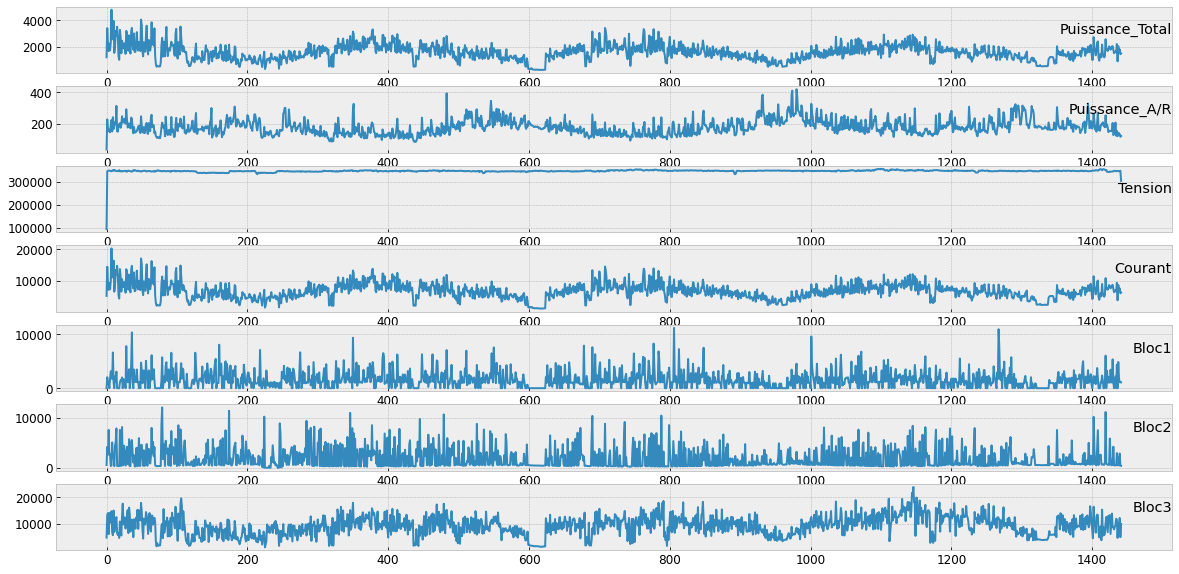

In [ ]:
values = df.values
groups = [0, 1, 2, 3, 4, 5, 6]
plt.figure(figsize=(20, 10))
i = 1
# plot each column
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(df.columns[group], y=0.5, loc='right')
    i += 1


plt.show()

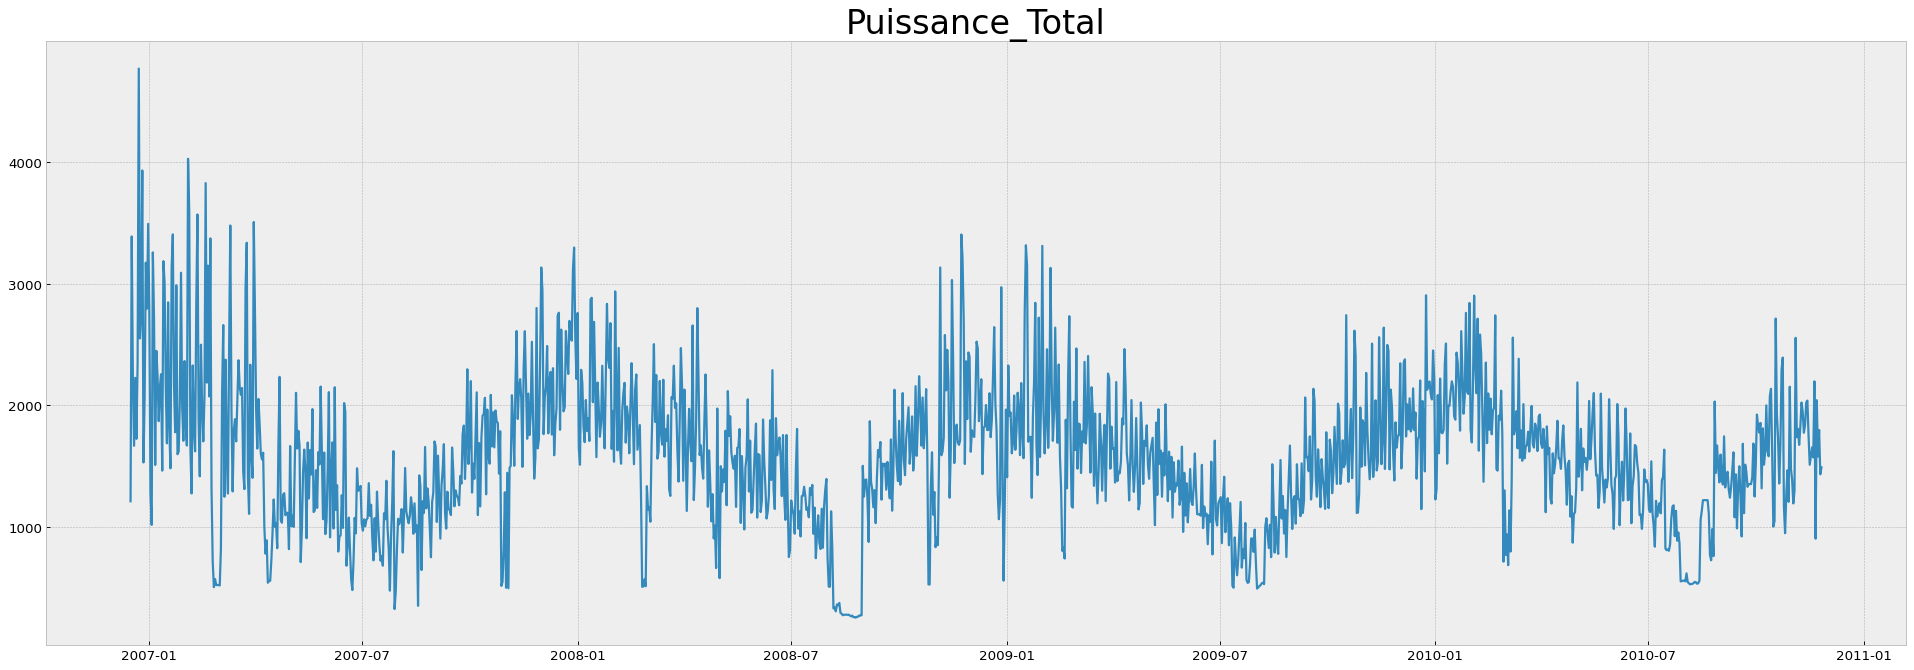

In [ ]:
plt.figure(num=None, figsize=(30, 10), dpi=80, facecolor='w', edgecolor='k')
plt.title('Puissance_Total', fontsize=30)

plt.plot(df.Puissance_Total)

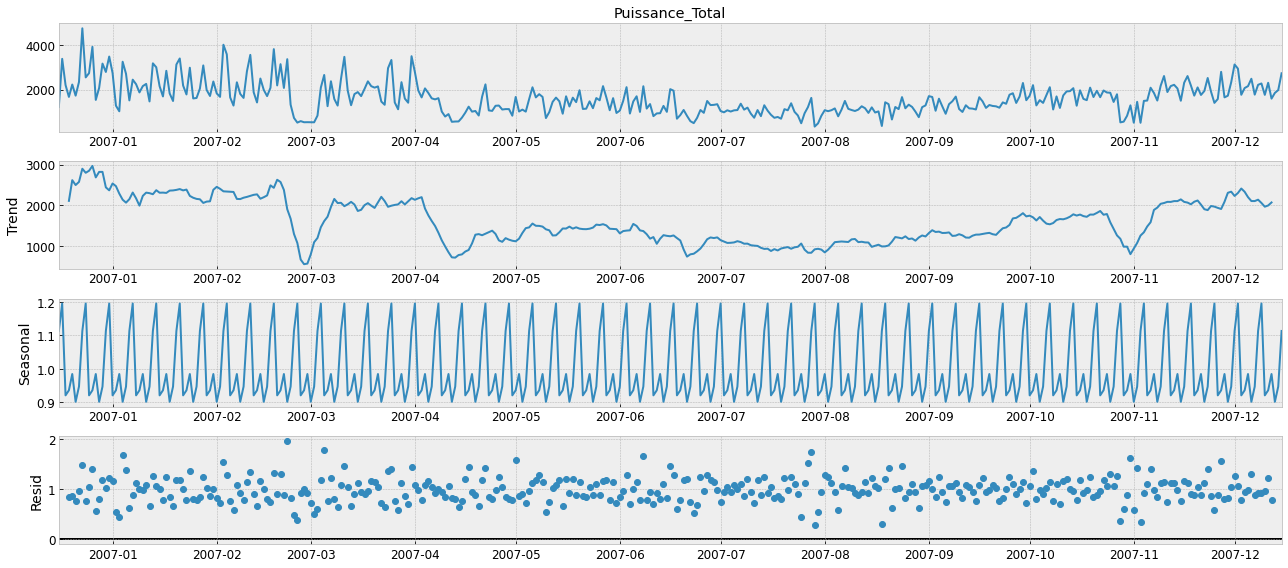

<Figure size 4000x1600 with 0 Axes>

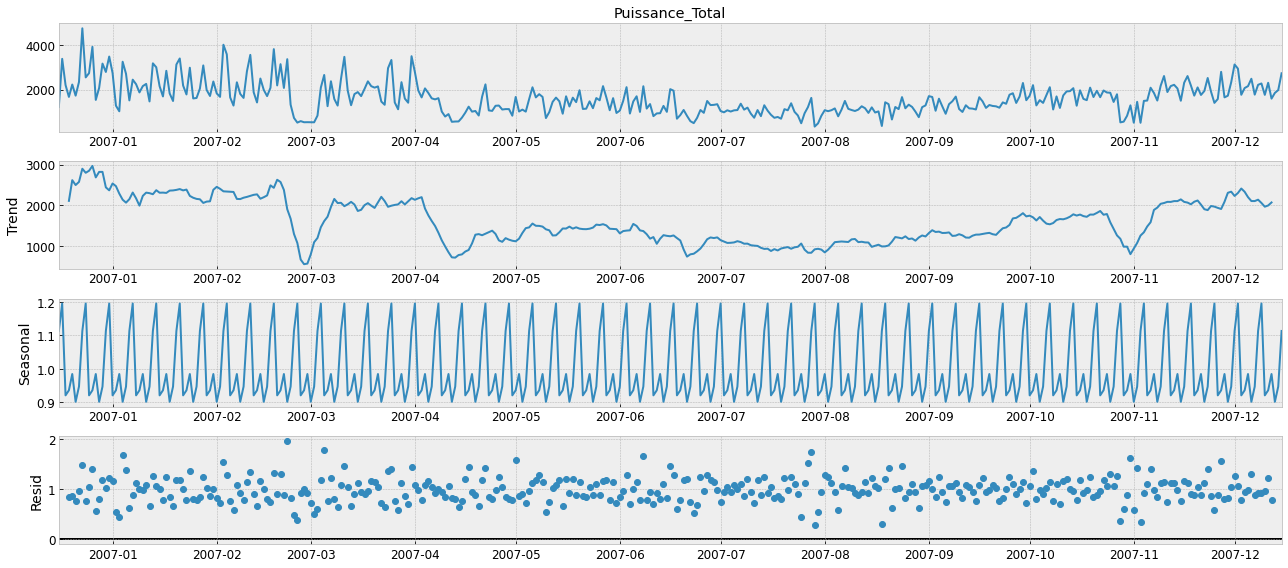

In [ ]:
rcParams['figure.figsize'] = 18, 8
plt.figure(num=None, figsize=(50, 20), dpi=80, facecolor='w', edgecolor='k')
series = df.Puissance_Total[:365]
result = seasonal_decompose(series, model='multiplicative')
result.plot()

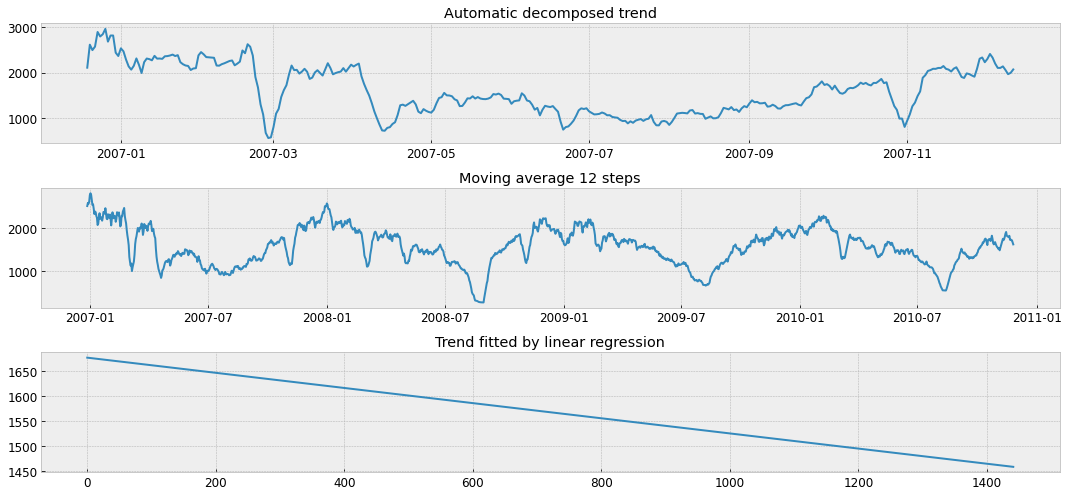

In [ ]:
fig = plt.figure(figsize=(15, 7))
layout = (3, 2)
pm_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
mv_ax = plt.subplot2grid(layout, (1, 0), colspan=2)
fit_ax = plt.subplot2grid(layout, (2, 0), colspan=2)

pm_ax.plot(result.trend)
pm_ax.set_title("Automatic decomposed trend")

mm = df.Puissance_Total.rolling(12).mean()
mv_ax.plot(mm)
mv_ax.set_title("Moving average 12 steps")


X = [i for i in range(0, len(df.Puissance_Total))]
X = np.reshape(X, (len(X), 1))
y = df.Puissance_Total.values
model = LinearRegression()
model.fit(X, y)
# calculate trend
trend = model.predict(X)
fit_ax.plot(trend)
fit_ax.set_title("Trend fitted by linear regression")

plt.tight_layout()

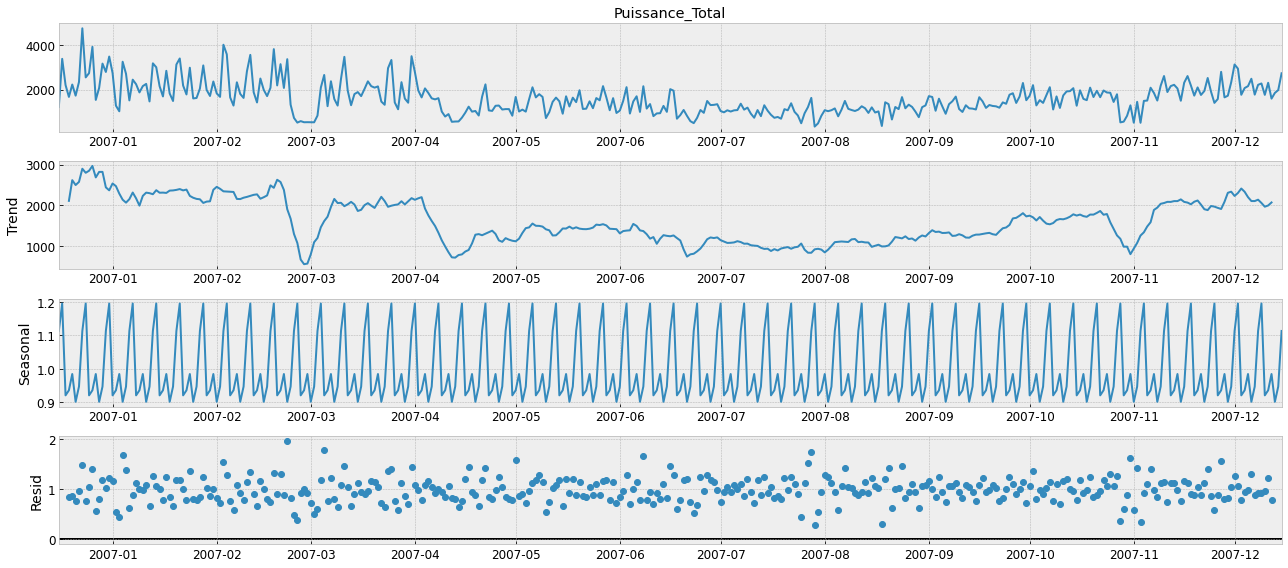

<Figure size 4000x1600 with 0 Axes>

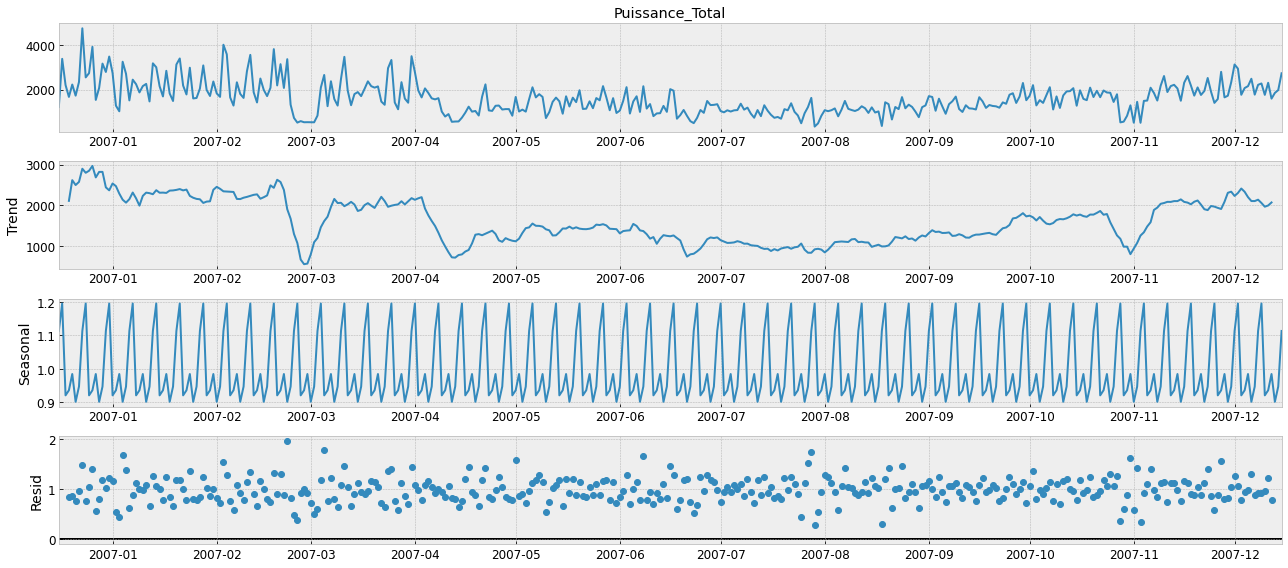

In [ ]:
rcParams['figure.figsize'] = 18, 8
plt.figure(num=None, figsize=(50, 20), dpi=80, facecolor='w', edgecolor='k')
series = df.Puissance_Total[:365]
result = seasonal_decompose(series, model='multiplicative')
result.plot()

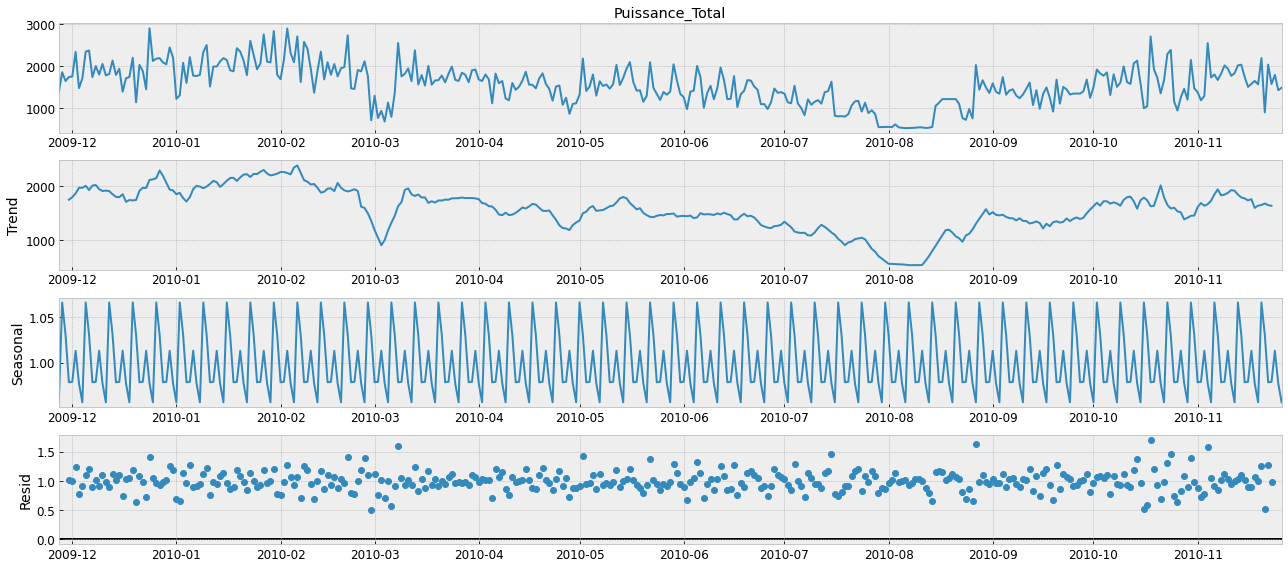

<Figure size 4000x1600 with 0 Axes>

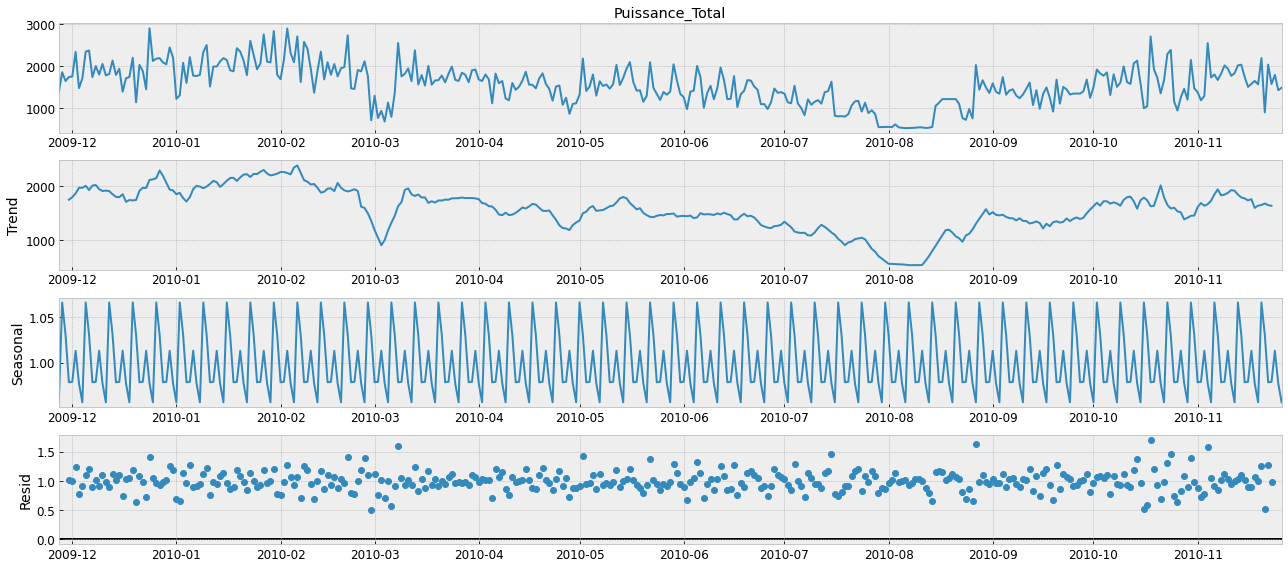

In [ ]:
rcParams['figure.figsize'] = 18, 8
plt.figure(num=None, figsize=(50, 20), dpi=80, facecolor='w', edgecolor='k')
series = df.Puissance_Total[-365:]
result = seasonal_decompose(series, model='multiplicative')
result.plot()

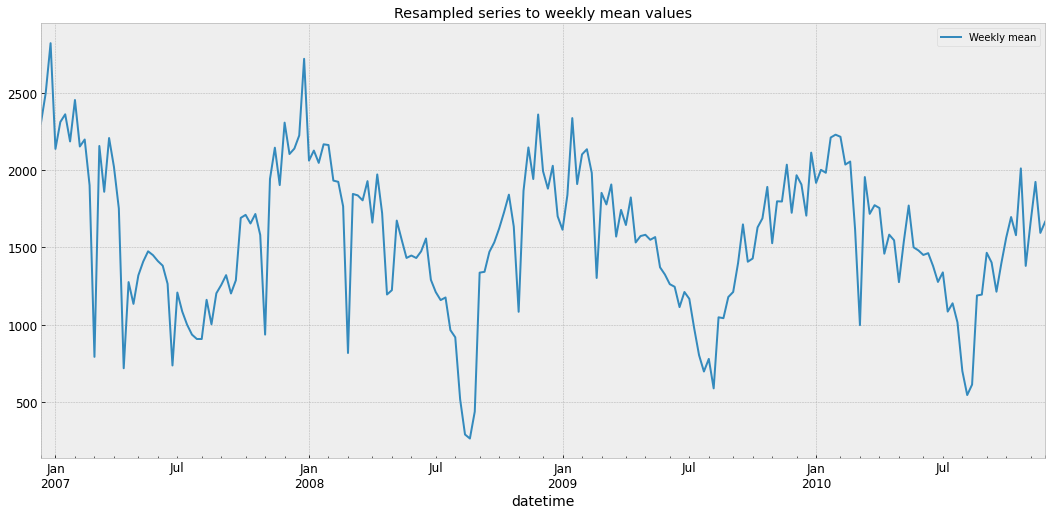

In [ ]:

# Looking for weekly seasonality
resample = df.resample('W')
weekly_mean = resample.mean()
weekly_mean.Puissance_Total.plot(label='Weekly mean')
plt.title("Resampled series to weekly mean values")
plt.legend()

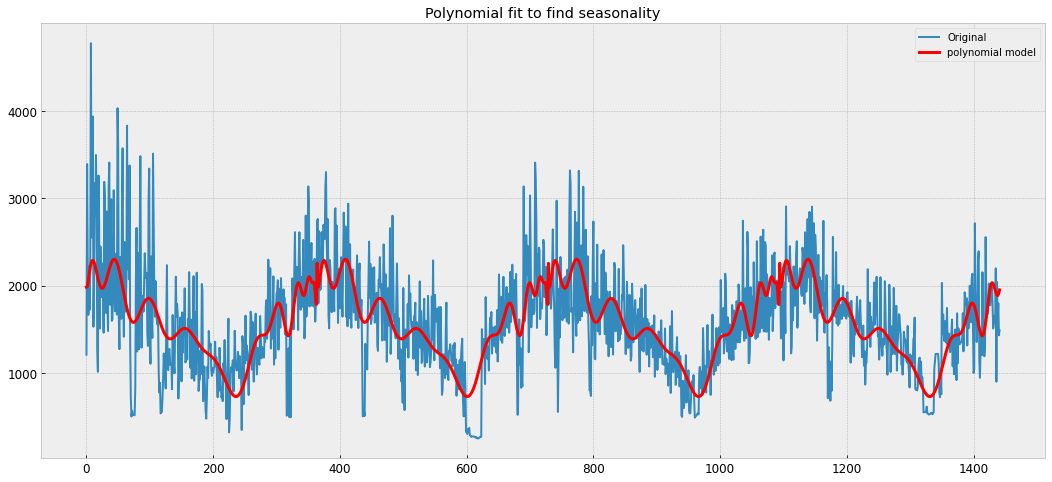

In [ ]:
# Fix xticks to show dates
# fit polynomial: x^2*b1 + x*b2 + ... + bn
series = df.Puissance_Total.values
X = [i % 365 for i in range(0, len(series))]
y = series
degree = 100
coef = np.polyfit(X, y, degree)
# create curve
curve = list()
for i in range(len(X)):
    value = coef[-1]
    for d in range(degree):
        value += X[i]**(degree-d) * coef[d]
    curve.append(value)
# plot curve over original data
plt.plot(series, label='Original')
plt.plot(curve, color='red', linewidth=3, label='polynomial model')
plt.legend()
plt.title("Polynomial fit to find seasonality")
plt.show()

Text(0.5, 1.0, 'Mean over time')

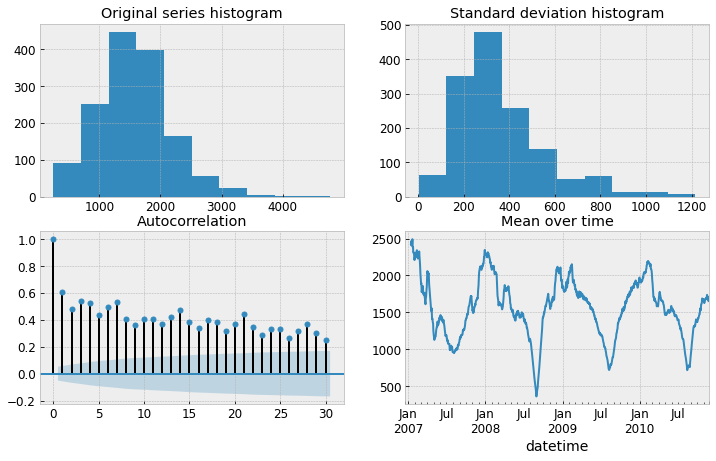

In [ ]:
fig = plt.figure(figsize=(12, 7))
layout = (2, 2)
hist_ax = plt.subplot2grid(layout, (0, 0))
ac_ax = plt.subplot2grid(layout, (1, 0))
hist_std_ax = plt.subplot2grid(layout, (0, 1))
mean_ax = plt.subplot2grid(layout, (1, 1))

df.Puissance_Total.hist(ax=hist_ax)
hist_ax.set_title("Original series histogram")

plot_acf(series, lags=30, ax=ac_ax)
ac_ax.set_title("Autocorrelation")

mm = df.Puissance_Total.rolling(7).std()
mm.hist(ax=hist_std_ax)
hist_std_ax.set_title("Standard deviation histogram")

mm = df.Puissance_Total.rolling(30).mean()
mm.plot(ax=mean_ax)
mean_ax.set_title("Mean over time")

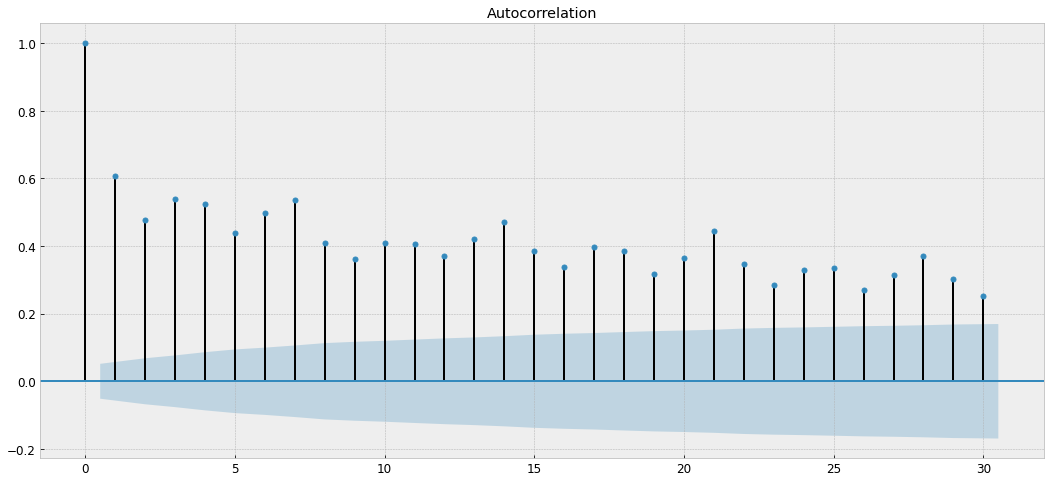

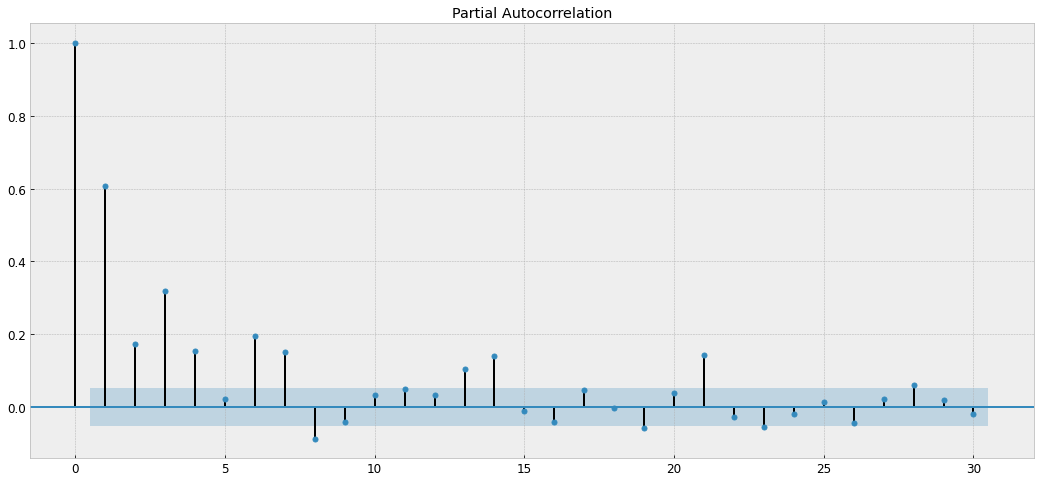

In [ ]:
plot_acf(series, lags=30)
plot_pacf(series, lags=30)
plt.show()

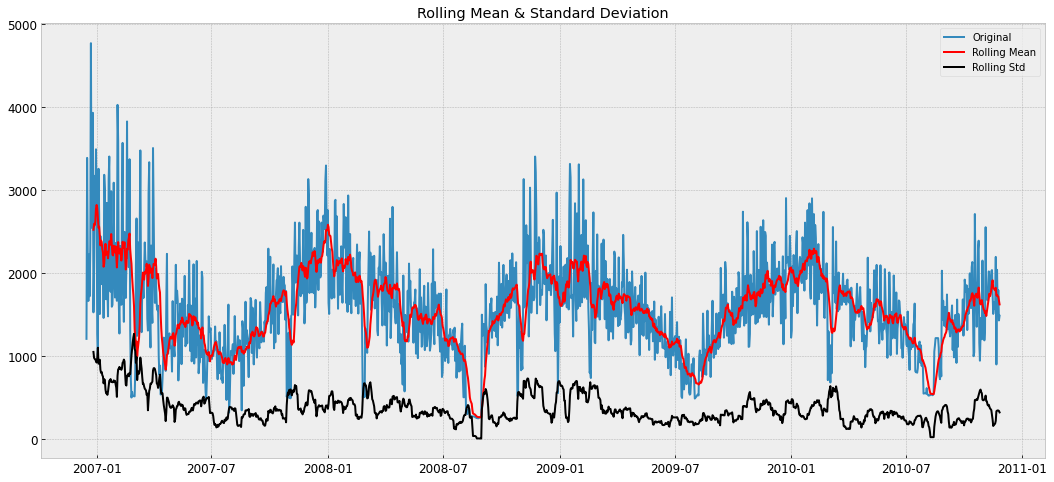

In [ ]:
# Determing rolling statistics
rolmean = df.Puissance_Total.rolling(window=12).mean()
rolstd = df.Puissance_Total.rolling(window=12).std()

# Plot rolling statistics:
orig = plt.plot(df.Puissance_Total, label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [ ]:
X = df.Puissance_Total.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.697385
p-value: 0.004150
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


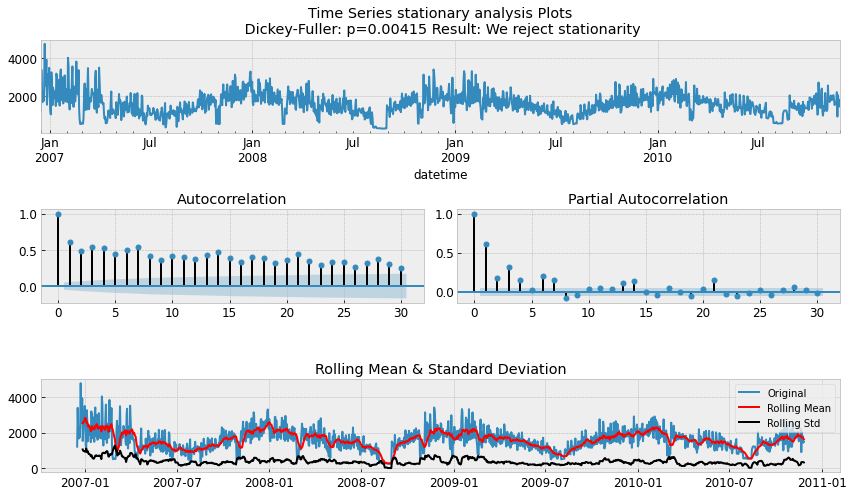

In [ ]:
def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=(12, 7))
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        mean_std_ax = plt.subplot2grid(layout, (2, 0), colspan=2)
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        hypothesis_result = "We reject stationarity" if p_value <= 0.05 else "We can not reject stationarity"
        ts_ax.set_title(
            'Time Series stationary analysis Plots\n Dickey-Fuller: p={0:.5f} Result: {1}'.format(p_value, hypothesis_result))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

        rolmean = df.Puissance_Total.rolling(window=12).mean()
        rolstd = df.Puissance_Total.rolling(window=12).std()

        # Plot rolling statistics:
        orig = plt.plot(df.Puissance_Total, label='Original')
        mean = plt.plot(rolmean, color='red', label='Rolling Mean')
        std = plt.plot(rolstd, color='black', label='Rolling Std')
        plt.legend(loc='best')
        plt.title('Rolling Mean & Standard Deviation')


tsplot(df.Puissance_Total, lags=30)

In [ ]:
def difference(dataset, interval=1, order=1):
    for u in range(order):
        diff = list()
        for i in range(interval, len(dataset)):
            value = dataset[i] - dataset[i - interval]
            diff.append(value)
        dataset = diff
    return diff
    

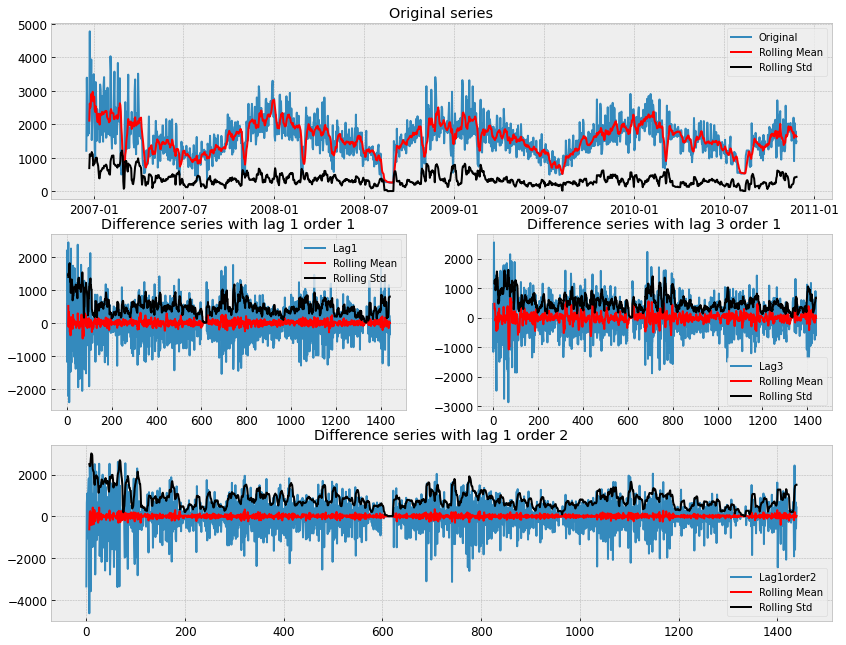

In [ ]:
lag1series = pd.Series(difference(df.Puissance_Total, interval=1, order=1))
lag3series = pd.Series(difference(df.Puissance_Total, interval=3, order=1))
lag1order2series = pd.Series(difference(
    df.Puissance_Total, interval=1, order=2))

fig = plt.figure(figsize=(14, 11))
layout = (3, 2)
original = plt.subplot2grid(layout, (0, 0), colspan=2)
lag1 = plt.subplot2grid(layout, (1, 0))
lag3 = plt.subplot2grid(layout, (1, 1))
lag1order2 = plt.subplot2grid(layout, (2, 0), colspan=2)

original.set_title('Original series')
original.plot(df.Puissance_Total, label='Original')
original.plot(df.Puissance_Total.rolling(
    7).mean(), color='red', label='Rolling Mean')
original.plot(df.Puissance_Total.rolling(7).std(),
              color='black', label='Rolling Std')
original.legend(loc='best')

lag1.set_title('Difference series with lag 1 order 1')
lag1.plot(lag1series, label="Lag1")
lag1.plot(lag1series.rolling(7).mean(), color='red', label='Rolling Mean')
lag1.plot(lag1series.rolling(7).std(), color='black', label='Rolling Std')
lag1.legend(loc='best')

lag3.set_title('Difference series with lag 3 order 1')
lag3.plot(lag3series, label="Lag3")
lag3.plot(lag3series.rolling(7).mean(), color='red', label='Rolling Mean')
lag3.plot(lag3series.rolling(7).std(), color='black', label='Rolling Std')
lag3.legend(loc='best')

lag1order2.set_title('Difference series with lag 1 order 2')
lag1order2.plot(lag1order2series, label="Lag1order2")
lag1order2.plot(lag1order2series.rolling(7).mean(),
                color='red', label='Rolling Mean')
lag1order2.plot(lag1order2series.rolling(7).std(),
                color='black', label='Rolling Std')
lag1order2.legend(loc='best')

Text(0.5, 1.0, 'Log scale transformation into original series')

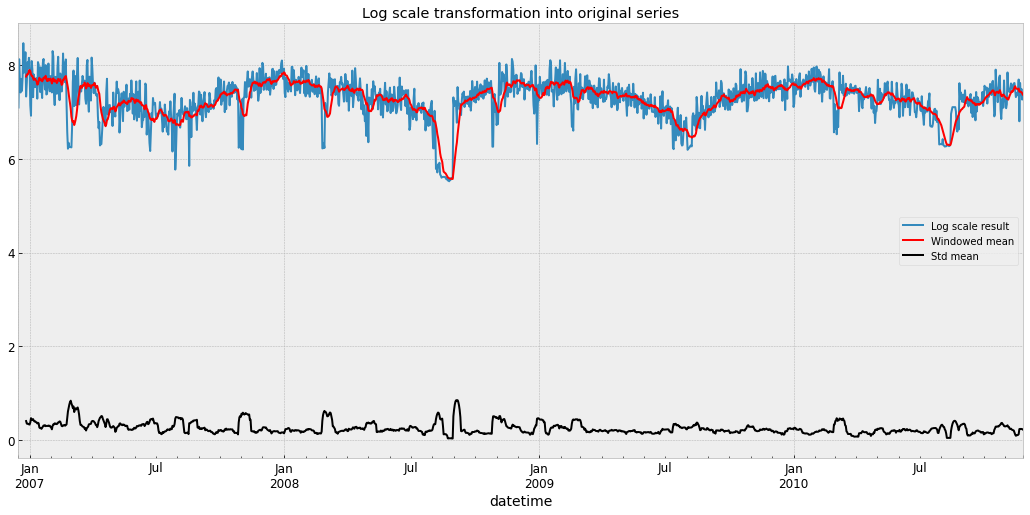

In [ ]:
ts_log = np.log(df.Puissance_Total)
ts_log.plot(label='Log scale result')
ts_log.rolling(window=12).mean().plot(color='red', label='Windowed mean')
ts_log.rolling(window=12).std().plot(color='black', label='Std mean')
plt.legend()
plt.title('Log scale transformation into original series')

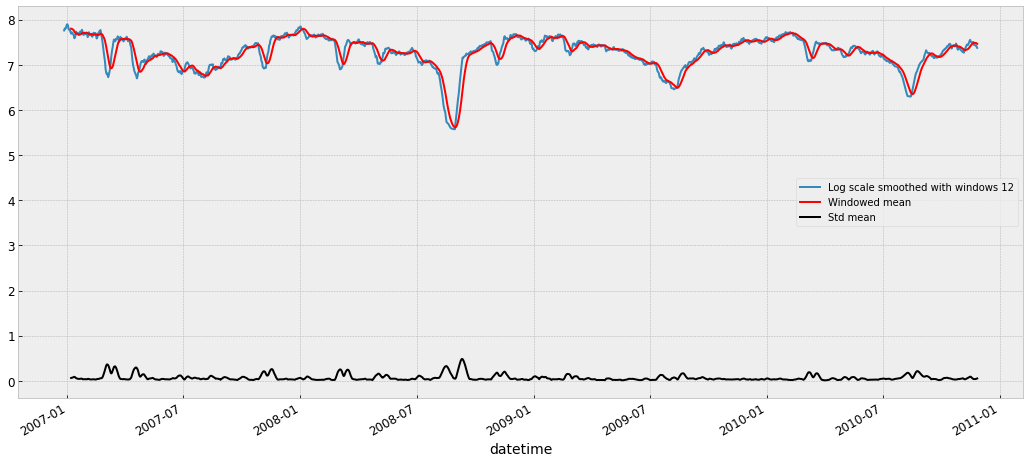

In [ ]:
avg = pd.Series(ts_log).rolling(12).mean()
plt.plot(avg, label='Log scale smoothed with windows 12')
avg.rolling(window=12).mean().plot(color='red', label='Windowed mean')
avg.rolling(window=12).std().plot(color='black', label='Std mean')
plt.legend()

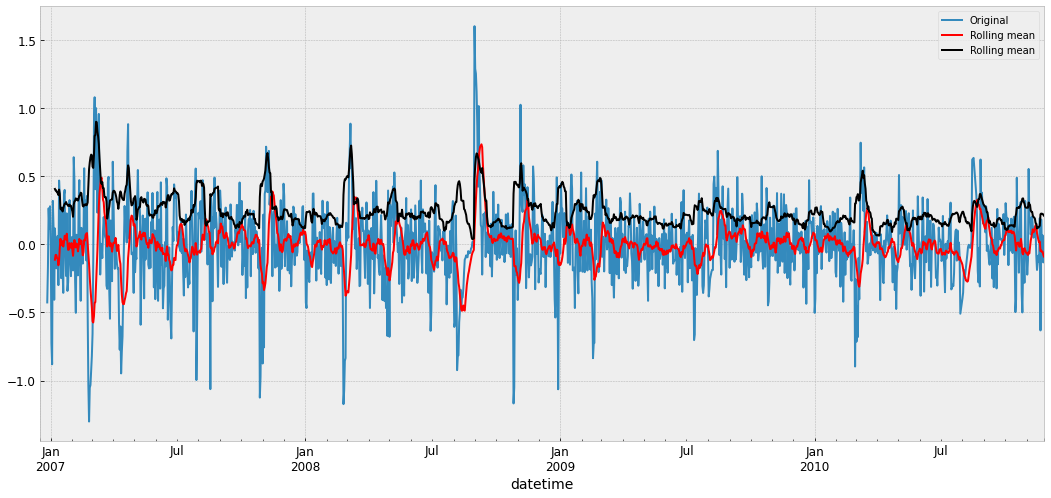

In [ ]:
ts_log_moving_avg_diff = ts_log - avg

ts_log_moving_avg_diff.plot(label='Original')
ts_log_moving_avg_diff.rolling(12).mean().plot(
    color='red', label="Rolling mean")
ts_log_moving_avg_diff.rolling(12).std().plot(
    color='black', label="Rolling mean")
plt.legend(loc='best')

In [ ]:
#prepare data for modelling


# We split our dataset to be able to evaluate our models

resultsDict = {}
predictionsDict = {}

split_date = '2010-01-01'
df_training = df.loc[df.index <= split_date]
df_test = df.loc[df.index > split_date]
print(f"{len(df_training)} days of training data \n {len(df_test)} days of testing data ")



1113 days of training data 
 329 days of testing data 


In [ ]:
#SES
# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(df_training)
yhat = list()
for t in tqdm(range(len(df_test.Puissance_Total))):
    temp_train = df[:len(df_training)+t]
    model = SimpleExpSmoothing(temp_train.Puissance_Total)
    model_fit = model.fit()
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train))
    yhat = yhat + [predictions]

yhat = pd.concat(yhat)
resultsDict['SES'] = evaluate(df_test.Puissance_Total, yhat.values)
predictionsDict['SES'] = yhat.values

100%|██████████| 329/329 [00:04<00:00, 76.92it/s]


In [ ]:
# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(df_training)
yhat = list()
for t in tqdm(range(len(df_test.Puissance_Total))):
    temp_train = df[:len(df_training)+t]
    model = ExponentialSmoothing(temp_train.Puissance_Total)
    model_fit = model.fit()
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train))
    yhat = yhat + [predictions]

yhat = pd.concat(yhat)
resultsDict['HWES'] = evaluate(df_test.Puissance_Total, yhat.values)
predictionsDict['HWES'] = yhat.values

100%|██████████| 329/329 [00:04<00:00, 75.90it/s]


In [ ]:
# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(df_training)
yhat = list()
for t in tqdm(range(len(df_test.Puissance_Total))):
    temp_train = df[:len(df_training)+t]
    model = AR(temp_train.Puissance_Total)
    model_fit = model.fit()
    predictions = model_fit.predict(
        start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]

yhat = pd.concat(yhat)
resultsDict['AR'] = evaluate(df_test.Puissance_Total, yhat.values)
predictionsDict['AR'] = yhat.values

100%|██████████| 329/329 [00:03<00:00, 86.26it/s]


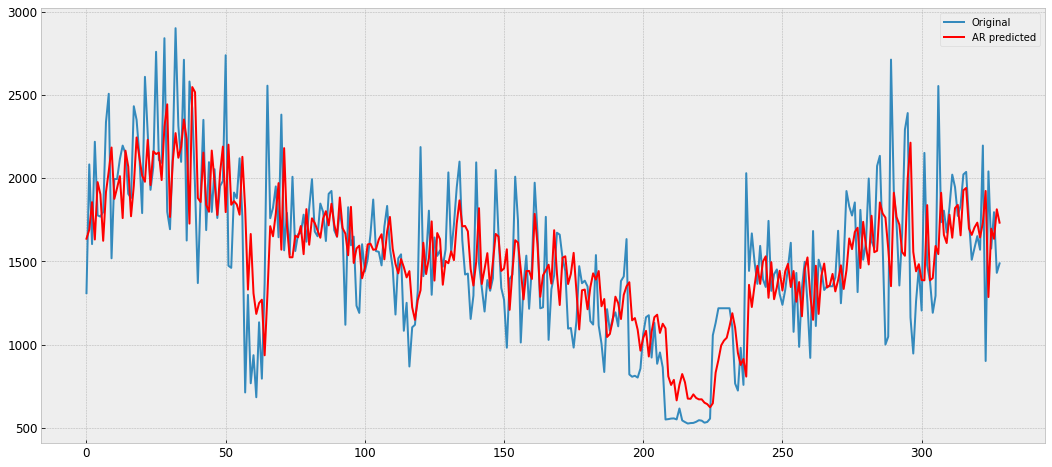

In [ ]:
plt.plot(df_test.Puissance_Total.values, label='Original')
plt.plot(yhat.values, color='red', label='AR predicted')
plt.legend()

In [ ]:
# MA example

# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(df_training)
yhat = list()
for t in tqdm(range(len(df_test.Puissance_Total))):
    temp_train = df[:len(df_training)+t]
    model = ARMA(temp_train.Puissance_Total, order=(0, 1))
    model_fit = model.fit(disp=False)
    predictions = model_fit.predict(
        start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]

yhat = pd.concat(yhat)
resultsDict['MA'] = evaluate(df_test.Puissance_Total, yhat.values)
predictionsDict['MA'] = yhat.values

100%|██████████| 329/329 [00:26<00:00, 12.47it/s]


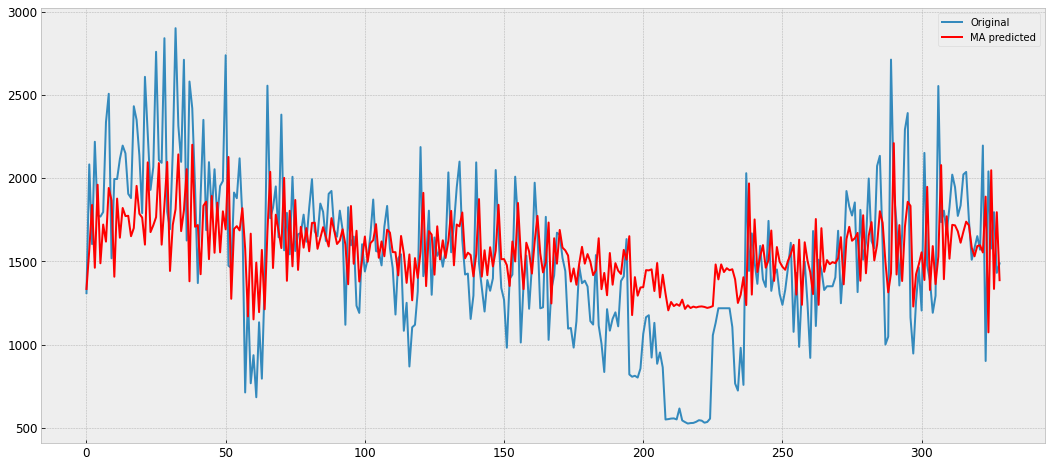

In [ ]:
plt.plot(df_test.Puissance_Total.values, label='Original')
plt.plot(yhat.values, color='red', label='MA predicted')
plt.legend()

In [ ]:
# ARMA example

# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(df_training)
yhat = list()
for t in tqdm(range(len(df_test.Puissance_Total))):
    temp_train = df[:len(df_training)+t]
    model = ARMA(temp_train.Puissance_Total, order=(1, 1))
    model_fit = model.fit(disp=False)
    predictions = model_fit.predict(
        start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]

yhat = pd.concat(yhat)
resultsDict['ARMA'] = evaluate(df_test.Puissance_Total, yhat.values)
predictionsDict['ARMA'] = yhat.values

100%|██████████| 329/329 [02:07<00:00,  2.58it/s]


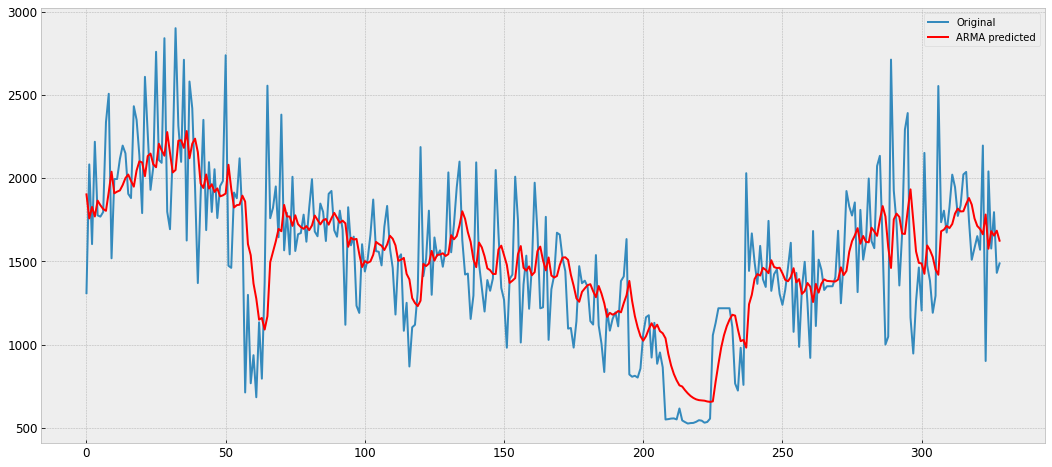

In [ ]:
plt.plot(df_test.Puissance_Total.values, label='Original')
plt.plot(yhat.values, color='red', label='ARMA predicted')
plt.legend()

In [ ]:
# ARIMA example

# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(df_training)
yhat = list()
for t in tqdm(range(len(df_test.Puissance_Total))):
    temp_train = df[:len(df_training)+t]
    model = ARIMA(temp_train.Puissance_Total, order=(1, 0, 0))
    model_fit = model.fit(disp=False)
    predictions = model_fit.predict(
        start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]

yhat = pd.concat(yhat)
resultsDict['ARIMA'] = evaluate(df_test.Puissance_Total, yhat.values)
predictionsDict['ARIMA'] = yhat.values

100%|██████████| 329/329 [00:27<00:00, 12.18it/s]


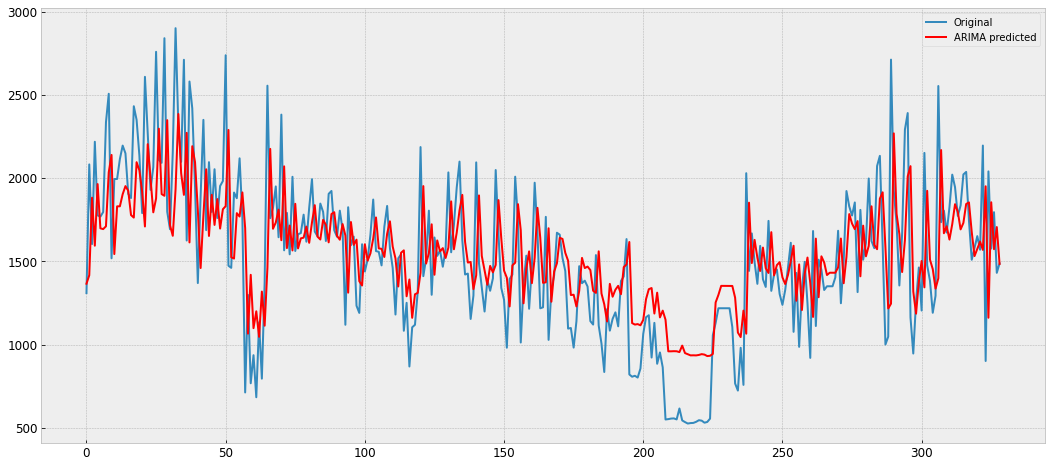

In [ ]:
plt.plot(df_test.Puissance_Total.values, label='Original')
plt.plot(yhat.values, color='red', label='ARIMA predicted')
plt.legend()

In [ ]:
# building the model

autoModel = pm.auto_arima(df_training.Puissance_Total, trace=True,
                          error_action='ignore', suppress_warnings=True, seasonal=False)
autoModel.fit(df_training.Puissance_Total)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=16800.720, Time=0.71 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=17231.615, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=17111.457, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=16853.127, Time=0.58 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=17229.615, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=16802.292, Time=0.86 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=16806.637, Time=1.29 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=16786.122, Time=2.30 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=16784.892, Time=1.65 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=16858.762, Time=0.25 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=16784.868, Time=2.47 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=16858.633, Time=0.33 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=16771.517, Time=0.93 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=16790.845, Time=0.52 sec
 ARIMA(5,1,2)(0,0,0

ARIMA(maxiter=50, method='lbfgs', order=(5, 1, 1), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=False)

In [ ]:
order = autoModel.order
yhat = list()
for t in tqdm(range(len(df_test.Puissance_Total))):
    temp_train = df[:len(df_training)+t]
    model = ARIMA(temp_train.Puissance_Total, order=order)
    model_fit = model.fit(disp=False)
    predictions = model_fit.predict(
        start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]

yhat = pd.concat(yhat)
resultsDict['AutoARIMA {0}'.format(order)] = evaluate(
    df_test.Puissance_Total, yhat)
predictionsDict['AutoARIMA {0}'.format(order)] = yhat.values

100%|██████████| 329/329 [03:41<00:00,  1.49it/s]


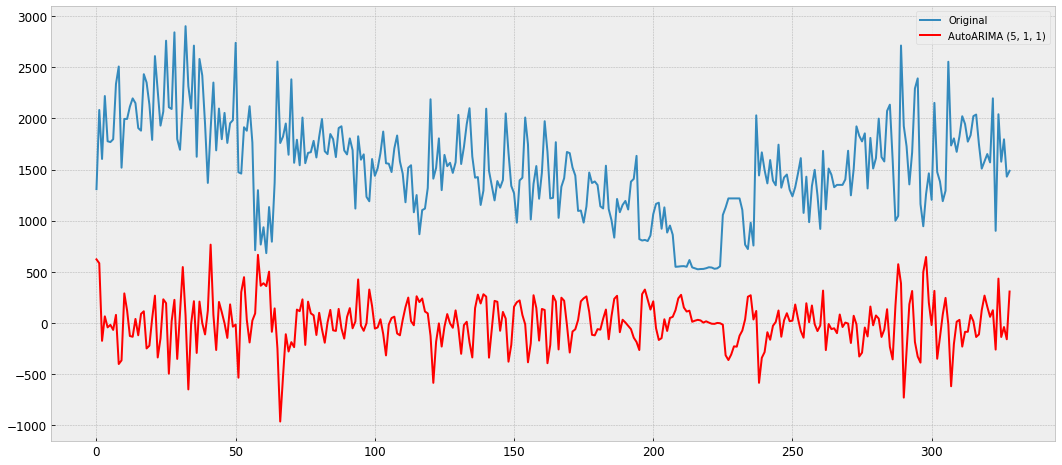

In [ ]:
plt.plot(df_test.Puissance_Total.values, label='Original')
plt.plot(yhat.values, color='red', label='AutoARIMA {0}'.format(order))
plt.legend()

In [ ]:
# SARIMA example

# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(df_training)
yhat = list()
for t in tqdm(range(len(df_test.Puissance_Total))):
    temp_train = df[:len(df_training)+t]
    model = SARIMAX(temp_train.Puissance_Total, order=(
        1, 0, 0), seasonal_order=(0, 0, 0, 3))
    model_fit = model.fit(disp=False)
    predictions = model_fit.predict(
        start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]

yhat = pd.concat(yhat)

100%|██████████| 329/329 [00:15<00:00, 21.47it/s]


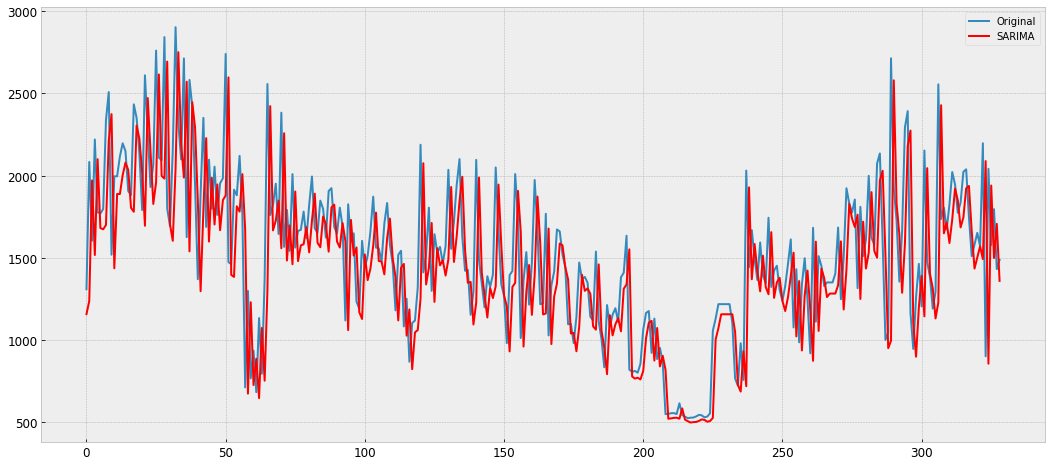

In [ ]:
plt.plot(df_test.Puissance_Total.values, label='Original')
plt.plot(yhat.values, color='red', label='SARIMA')
plt.legend()

In [ ]:
# Prophet needs some specifics data stuff, coment it here
prophet_training = df_training.rename(
    columns={'Puissance_Total': 'y'})  # old method
prophet_training['ds'] = prophet_training.index
prophet_training.index = pd.RangeIndex(len(prophet_training.index))

prophet_test = df_test.rename(columns={'Puissance_Total': 'y'})  # old method
prophet_test['ds'] = prophet_test.index
prophet_test.index = pd.RangeIndex(len(prophet_test.index))

In [ ]:
prophet = Prophet(
    growth='linear',
    seasonality_mode='multiplicative',
    holidays_prior_scale=20,
    daily_seasonality=False,
    weekly_seasonality=False,
    yearly_seasonality=False
).add_seasonality(
    name='monthly',
    period=30.5,
    fourier_order=55
).add_seasonality(
    name='daily',
    period=1,
    fourier_order=15
).add_seasonality(
    name='weekly',
    period=7,
    fourier_order=25
).add_seasonality(
    name='yearly',
    period=365.25,
    fourier_order=20
).add_seasonality(
    name='quarterly',
    period=365.25/4,
    fourier_order=55
).add_country_holidays(country_name='Switzerland')

In [ ]:
prophet.fit(prophet_training)
yhat = prophet.predict(prophet_test)
resultsDict['Prophet univariate'] = evaluate(
    df_test.pollution_today, yhat.yhat.values)
predictionsDict['Prophet univariate'] = yhat.yhat.values

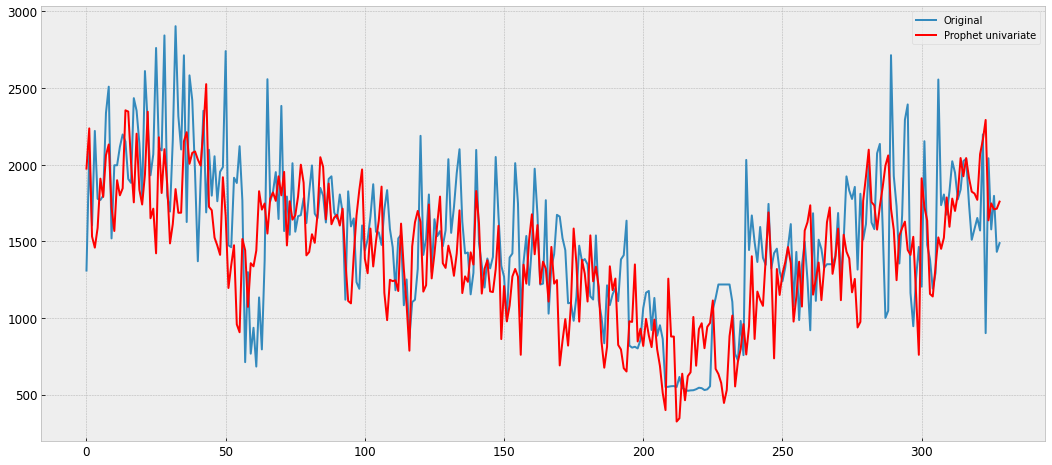

In [ ]:
plt.plot(df_test.Puissance_Total.values, label='Original')
plt.plot(yhat.yhat, color='red', label='Prophet univariate')
plt.legend()

[texte du lien](https://)Multivariate time series forecasting

In [ ]:
# ADD time features to our model
def create_time_features(df, target=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['sin_day'] = np.sin(df['dayofyear'])
    df['cos_day'] = np.cos(df['dayofyear'])
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    X = df.drop(['date'], axis=1)
    if target:
        y = df[target]
        X = X.drop([target], axis=1)
        return X, y

    return X

In [ ]:
X_train_df, y_train = create_time_features(
    df_training, target='Puissance_Total')
X_test_df, y_test = create_time_features(df_test, target='Puissance_Total')
scaler = StandardScaler()
scaler.fit(X_train_df)  # No cheating, never scale on the training+test!
X_train = scaler.transform(X_train_df)
X_test = scaler.transform(X_test_df)

X_train_df = pd.DataFrame(X_train, columns=X_train_df.columns)
X_test_df = pd.DataFrame(X_test, columns=X_test_df.columns)

In [ ]:
#Linear Regression Baseyian Regression

reg = linear_model.BayesianRidge()
reg.fit(X_train, y_train)
yhat = reg.predict(X_test)
resultsDict['BayesianRidge'] = evaluate(df_test.Puissance_Total, yhat)
predictionsDict['BayesianRidge'] = yhat

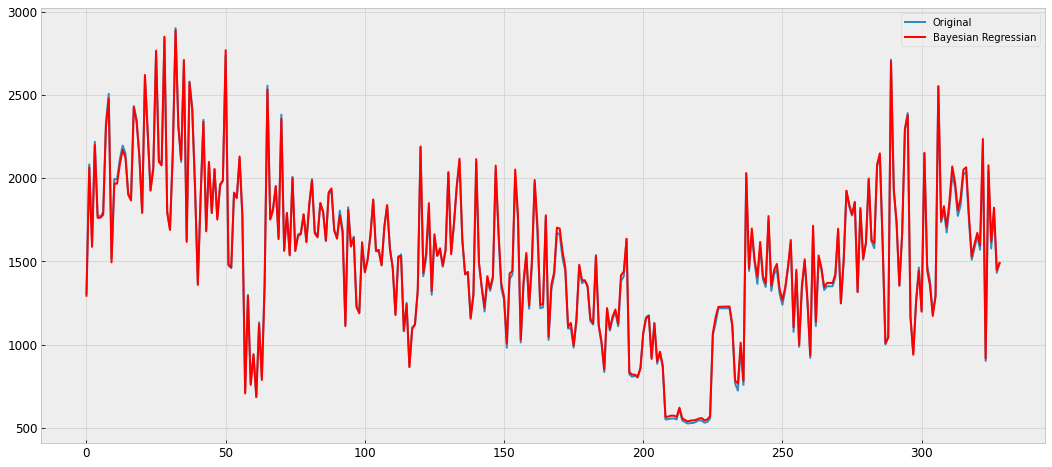

In [ ]:
plt.plot(df_test.Puissance_Total.values, label='Original')
plt.plot(yhat, color='red', label='Bayesian Regressian')
plt.legend()

In [ ]:
#Lasso
reg = linear_model.Lasso(alpha=0.1)
reg.fit(X_train, y_train)
yhat = reg.predict(X_test)
resultsDict['Lasso'] = evaluate(df_test.Puissance_Total, yhat)
predictionsDict['Lasso'] = yhat

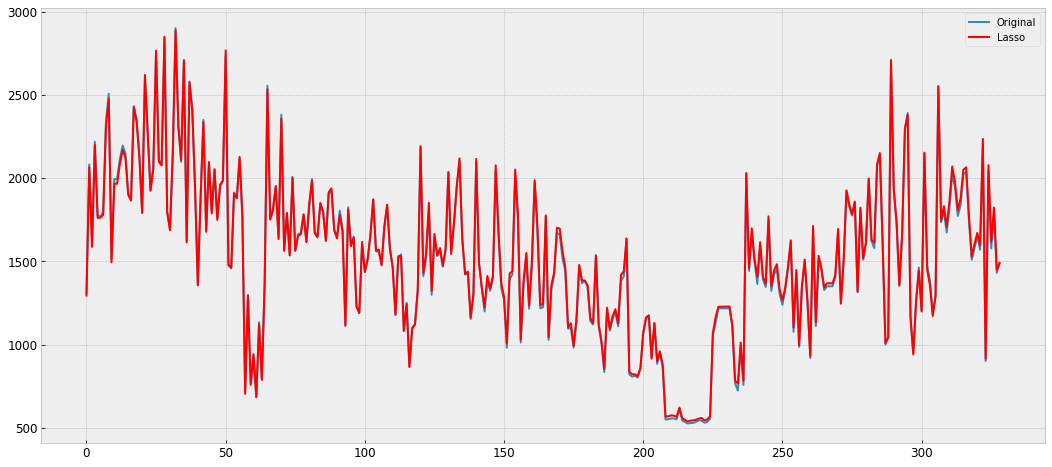

In [ ]:
plt.plot(df_test.Puissance_Total.values, label='Original')
plt.plot(yhat, color='red', label='Lasso')
plt.legend()

In [ ]:
#Random Forest
reg = RandomForestRegressor(max_depth=2, random_state=0)
reg.fit(X_train, y_train)
yhat = reg.predict(X_test)
resultsDict['Randomforest'] = evaluate(df_test.Puissance_Total, yhat)
predictionsDict['Randomforest'] = yhat

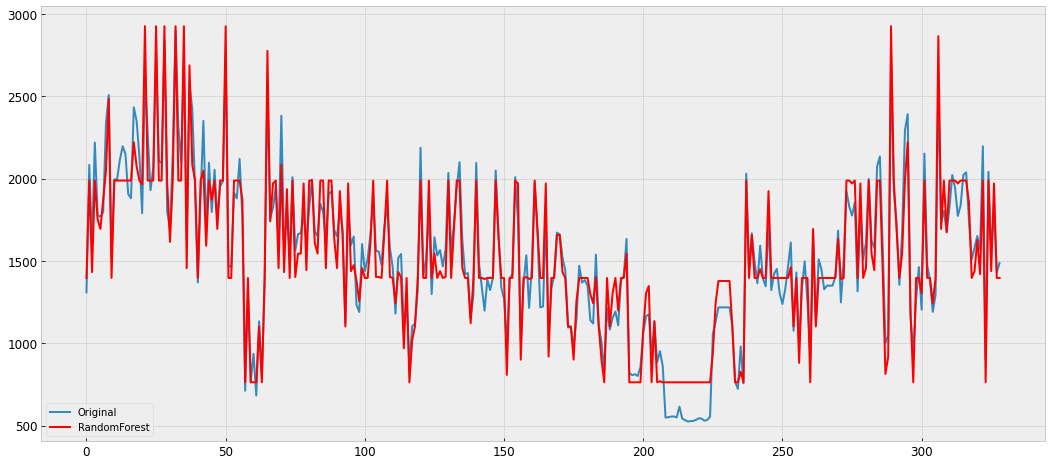

In [ ]:
plt.plot(df_test.Puissance_Total.values, label='Original')
plt.plot(yhat, color='red', label='RandomForest')
plt.legend()

In [ ]:
reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000)
reg.fit(X_train, y_train,
        verbose=False)  # Change verbose to True if you want to see it train
yhat = reg.predict(X_test)
resultsDict['XGBoost'] = evaluate(df_test.Puissance_Total, yhat)
predictionsDict['XGBoost'] = yhat

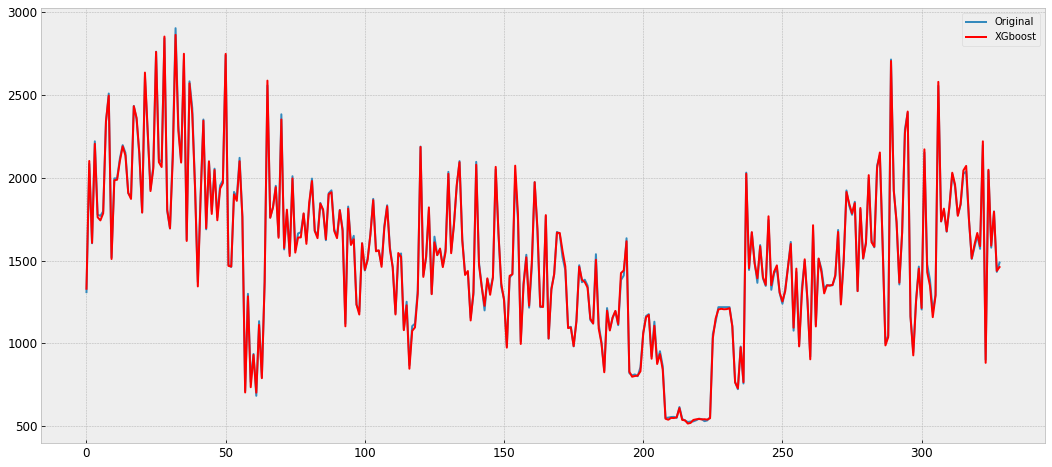

In [ ]:
plt.plot(df_test.Puissance_Total.values, label='Original')
plt.plot(yhat, color='red', label='XGboost')
plt.legend()

In [ ]:
lightGBM = lgb.LGBMRegressor()
lightGBM.fit(X_train, y_train)
yhat = lightGBM.predict(X_test)
resultsDict['Lightgbm'] = evaluate(df_test.Puissance_Total, yhat)
predictionsDict['Lightgbm'] = yhat


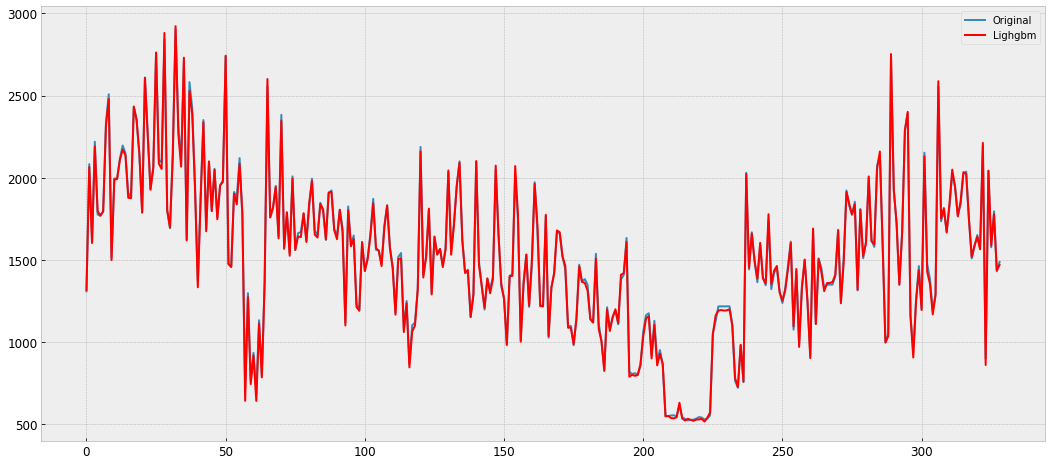

In [ ]:
plt.plot(df_test.Puissance_Total.values, label='Original')
plt.plot(yhat, color='red', label='Lighgbm')
plt.legend()

In [ ]:
reg = svm.SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
reg.fit(X_train, y_train)
yhat = reg.predict(X_test)
resultsDict['SVM RBF'] = evaluate(df_test.Puissance_Total, yhat)
predictionsDict['SVM RBF'] = yhat

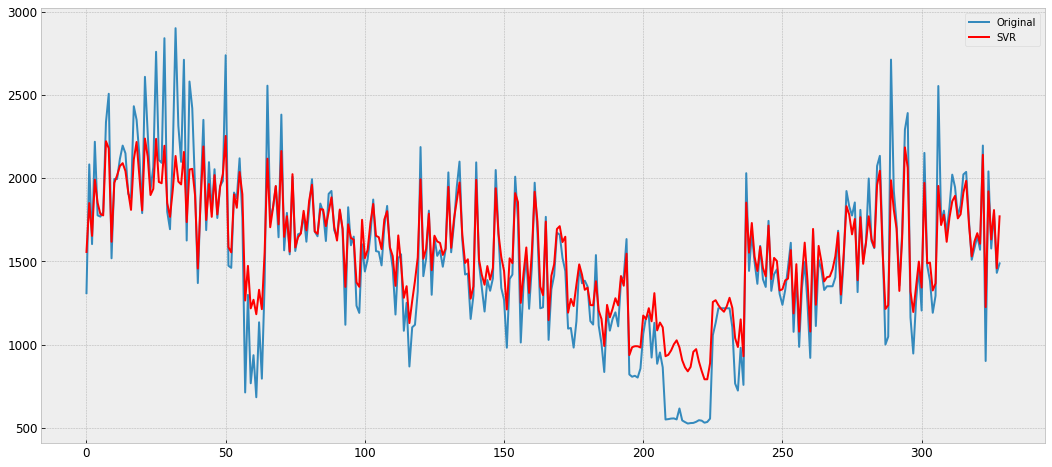

In [ ]:
plt.plot(df_test.Puissance_Total.values, label='Original')
plt.plot(yhat, color='red', label='SVR')
plt.legend()

In [ ]:
reg = KNeighborsRegressor(n_neighbors=2)
reg.fit(X_train, y_train)
yhat = reg.predict(X_test)
resultsDict['Kneighbors'] = evaluate(df_test.Puissance_Total, yhat)
predictionsDict['Kneighbors'] = yhat

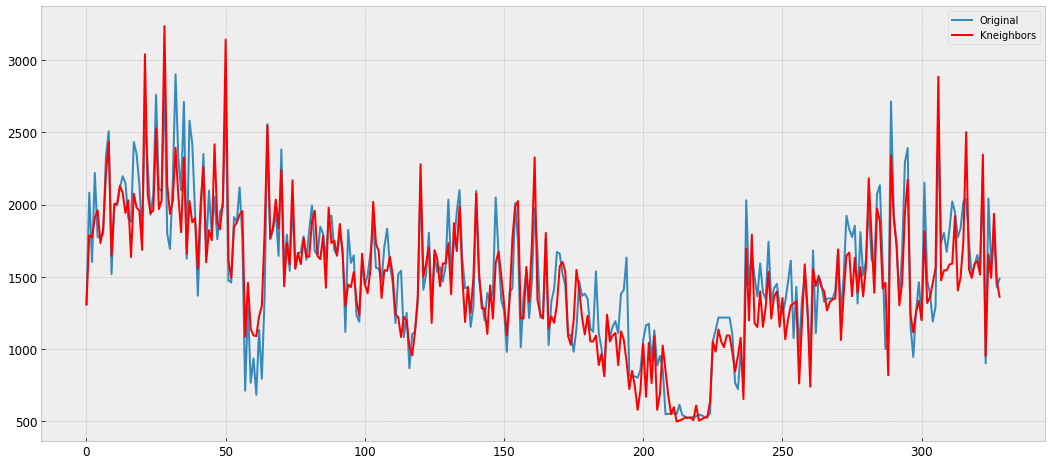

In [ ]:
plt.plot(df_test.Puissance_Total.values, label='Original')
plt.plot(yhat, color='red', label='Kneighbors')
plt.legend()

In [ ]:
prophet = Prophet(
    growth='linear',
    seasonality_mode='multiplicative',
    daily_seasonality=True,
).add_country_holidays(country_name='Switzerland')


for col in prophet_training.columns:
    if col not in ["ds", "y"]:
        prophet.add_regressor(col)

In [ ]:
prophet.fit(prophet_training)
yhat = prophet.predict(prophet_test)
resultsDict['Prophet multivariate'] = evaluate(y_test, yhat.yhat.values)
predictionsDict['Prophet multivariate'] = yhat.yhat.values

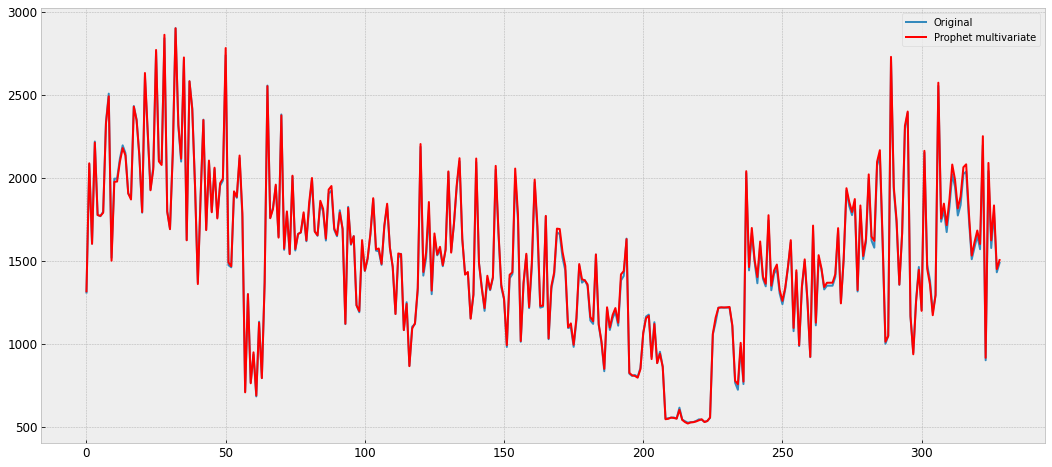

In [ ]:
plt.plot(df_test.Puissance_Total.values, label='Original')
plt.plot(yhat.yhat, color='red', label='Prophet multivariate')
plt.legend()

In [ ]:
#Deep learning 
#####LSTM#######
# For our dl model we will create windows of data that will be feeded into the datasets, for each timestemp T we will append the data from T-7 to T to the Xdata with target Y(t)
BATCH_SIZE = 64
BUFFER_SIZE = 100
WINDOW_LENGTH = 24





def window_data(X, Y, window=7):
    '''
    The dataset length will be reduced to guarante all samples have the window, so new length will be len(dataset)-window
    '''
    x = []
    y = []
    for i in range(window-1, len(X)):
        x.append(X[i-window+1:i+1])
        y.append(Y[i])
    return np.array(x), np.array(y)


# Since we are doing sliding, we need to join the datasets again of train and test
X_w = np.concatenate((X_train, X_test))
y_w = np.concatenate((y_train, y_test))

X_w, y_w = window_data(X_w, y_w, window=WINDOW_LENGTH)
X_train_w = X_w[:-len(X_test)]
y_train_w = y_w[:-len(X_test)]
X_test_w = X_w[-len(X_test):]
y_test_w = y_w[-len(X_test):]

# Check we will have same test set as in the previous models, make sure we didnt screw up on the windowing
print(f"Test set equal: {np.array_equal(y_test_w,y_test)}")

train_data = tf.data.Dataset.from_tensor_slices((X_train_w, y_train_w))
train_data = train_data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data = tf.data.Dataset.from_tensor_slices((X_test_w, y_test_w))
val_data = val_data.batch(BATCH_SIZE).repeat()

Test set equal: True


In [ ]:
dropout = 10.0
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(
        128, input_shape=X_train_w.shape[-2:], dropout=dropout),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

In [ ]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

model_history = simple_lstm_model.fit(train_data, epochs=EPOCHS,
                                      steps_per_epoch=EVALUATION_INTERVAL,
                                      validation_data=val_data, validation_steps=50)  # ,callbacks=[tensorboard_callback]) #Uncomment this line for tensorboard support

Epoch 1/10
200/200 [==============================] - 13s 52ms/step - loss: 551.9146 - val_loss: 234.4405
Epoch 2/10
200/200 [==============================] - 10s 48ms/step - loss: 154.5889 - val_loss: 94.6553
Epoch 3/10
200/200 [==============================] - 9s 47ms/step - loss: 103.3284 - val_loss: 106.4371
Epoch 4/10
200/200 [==============================] - 10s 48ms/step - loss: 82.8191 - val_loss: 57.5270
Epoch 5/10
200/200 [==============================] - 10s 48ms/step - loss: 69.0290 - val_loss: 62.9424
Epoch 6/10
200/200 [==============================] - 10s 48ms/step - loss: 58.9049 - val_loss: 56.2029
Epoch 7/10
200/200 [==============================] - 10s 49ms/step - loss: 55.8309 - val_loss: 34.0130
Epoch 8/10
200/200 [==============================] - 10s 48ms/step - loss: 51.3684 - val_loss: 79.9251
Epoch 9/10
200/200 [==============================] - 10s 50ms/step - loss: 48.7061 - val_loss: 49.8799
Epoch 10/10
200/200 [==============================] - 10s 4

In [ ]:
yhat = simple_lstm_model.predict(X_test_w).reshape(1, -1)[0]
resultsDict['LSTM'] = evaluate(y_test, yhat)
predictionsDict['LSTM'] = yhat

In [ ]:
reg = GridSearchCV(svm.SVR(kernel='rbf', gamma=0.1),
                   param_grid={"C": [1e0, 1e1, 1e2, 1e3],
                               "gamma": np.logspace(-2, 2, 5)})
reg.fit(X_train, y_train)
yhat = reg.predict(X_test)
resultsDict['SVM RBF GRID SEARCH'] = evaluate(df_test.Puissance_Total, yhat)
predictionsDict['SVM RBF GRID SEARCH'] = yhat

Hyperparameter optimization


In [ ]:
reg = GridSearchCV(svm.SVR(kernel='rbf', gamma=0.1),
                   param_grid={"C": [1e0, 1e1, 1e2, 1e3],
                               "gamma": np.logspace(-2, 2, 5)})
reg.fit(X_train, y_train)
yhat = reg.predict(X_test)
resultsDict['SVM RBF GRID SEARCH'] = evaluate(df_test.Puissance_Total, yhat)
predictionsDict['SVM RBF GRID SEARCH'] = yhat

In [ ]:
increase = 1 - (resultsDict['SVM RBF GRID SEARCH']
                ['rmse']/resultsDict['SVM RBF']['rmse'])
print(
    f"Grid search Tunned SVM is {increase*100}% better than the SVM with default parameters")

Grid search Tunned SVM is 84.28125239497888% better than the SVM with default parameters


Combining Models For Better Performance

In [ ]:
models = ['LSTM',
          'Lightgbm',
          'XGBoost']
resis = pd.DataFrame(data={k: df_test.Puissance_Total.values -
                     v for k, v in predictionsDict.items()})[models]
corr = resis.corr()
print("Residuals correlation")
corr.style.background_gradient(cmap='coolwarm')

Residuals correlation


In [ ]:
predictionsDict['EnsembleXG+LIGHT'] = (
    predictionsDict['XGBoost'] + predictionsDict['Lightgbm'])/2
resultsDict['EnsembleXG+LIGHT'] = evaluate(
    df_test.Puissance_Total.values, predictionsDict['EnsembleXG+LIGHT'])

predictionsDict['EnsembleXG+LIGHT+LSTM'] = (predictionsDict['XGBoost'] +
                                          predictionsDict['Lightgbm'] + predictionsDict['LSTM'])/3
resultsDict['EnsembleXG+LIGHT+LSTM'] = evaluate(
    df_test.Puissance_Total.values, predictionsDict['EnsembleXG+LIGHT+LSTM'])

predictionsDict['EnsembleLIGHT+LSTM'] = (
    predictionsDict['Lightgbm'] + predictionsDict['LSTM'])/2
resultsDict['EnsembleLIGHT+LSTM'] = evaluate(
    df_test.Puissance_Total.values, predictionsDict['EnsembleLIGHT+LSTM'])

predictionsDict['EnsembleXG+LSTM'] = (predictionsDict['XGBoost'] +
                                    predictionsDict['LSTM'])/2
resultsDict['EnsembleXG+LSTM'] = evaluate(
    df_test.Puissance_Total.values, predictionsDict['EnsembleXG+LSTM'])

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd


def bar_metrics(resultsDict):
    df = pd.DataFrame.from_dict(resultsDict)
    colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    pallette = plt.cm.get_cmap("tab20c", len(df.columns))
    colors = [pallette(x) for x in range(len(df.columns))]
    color_dict = dict(zip(df.columns, colors))
    fig = plt.figure(figsize=(20, 15))

    # MAE plot
    fig.add_subplot(2, 2, 1)
    df.loc["mae"].sort_values().plot(
        kind="bar",
        colormap="Paired",
        color=[color_dict.get(x, "#333333") for x in df.loc["mae"].sort_values().index],
    )
    plt.legend()
    plt.title("MAE Metric, lower is better")
    fig.add_subplot(2, 2, 2)
    df.loc["rmse"].sort_values().plot(
        kind="bar",
        colormap="Paired",
        color=[
            color_dict.get(x, "#333333") for x in df.loc["rmse"].sort_values().index
        ],
    )
    plt.legend()
    plt.title("RMSE Metric, lower is better")
    fig.add_subplot(2, 2, 3)
    df.loc["mape"].sort_values().plot(
        kind="bar",
        colormap="Paired",
        color=[
            color_dict.get(x, "#333333") for x in df.loc["mape"].sort_values().index
        ],
    )
    plt.legend()
    plt.title("MAPE Metric, lower is better")
    fig.add_subplot(2, 2, 4)
    df.loc["r2"].sort_values(ascending=False).plot(
        kind="bar",
        colormap="Paired",
        color=[
            color_dict.get(x, "#333333")
            for x in df.loc["r2"].sort_values(ascending=False).index
        ],
    )
    plt.legend()
    plt.title("R2 Metric, higher is better")
    plt.tight_layout()
    #plt.savefig("results/metrics.png")
    plt.show()


In [ ]:
def full_extent(ax, pad=0.0):
    """Get the full extent of an axes, including axes labels, tick labels, and
    titles."""
    # For text objects, we need to draw the figure first, otherwise the extents
    # are undefined.
    ax.figure.canvas.draw()
    items = ax.get_xticklabels() + ax.get_yticklabels()
#    items += [ax, ax.title, ax.xaxis.label, ax.yaxis.label]
    items += [ax, ax.title]
    bbox = Bbox.union([item.get_window_extent() for item in items])

    return bbox.expanded(1.0 + pad, 1.0 + pad)

In [ ]:
dff = pd.DataFrame.from_dict(resultsDict)
dff

SES        HWES  ...  EnsembleLIGHT+LSTM  EnsembleXG+LSTM
mae   248.546374  248.546374  ...           17.463605        17.009666
rmse  338.768535  338.768535  ...           22.555612        22.244035
mape    0.178416    0.178416  ...            0.012497         0.012313
r2      0.500438    0.500438  ...            0.997785         0.997846

[4 rows x 21 columns]

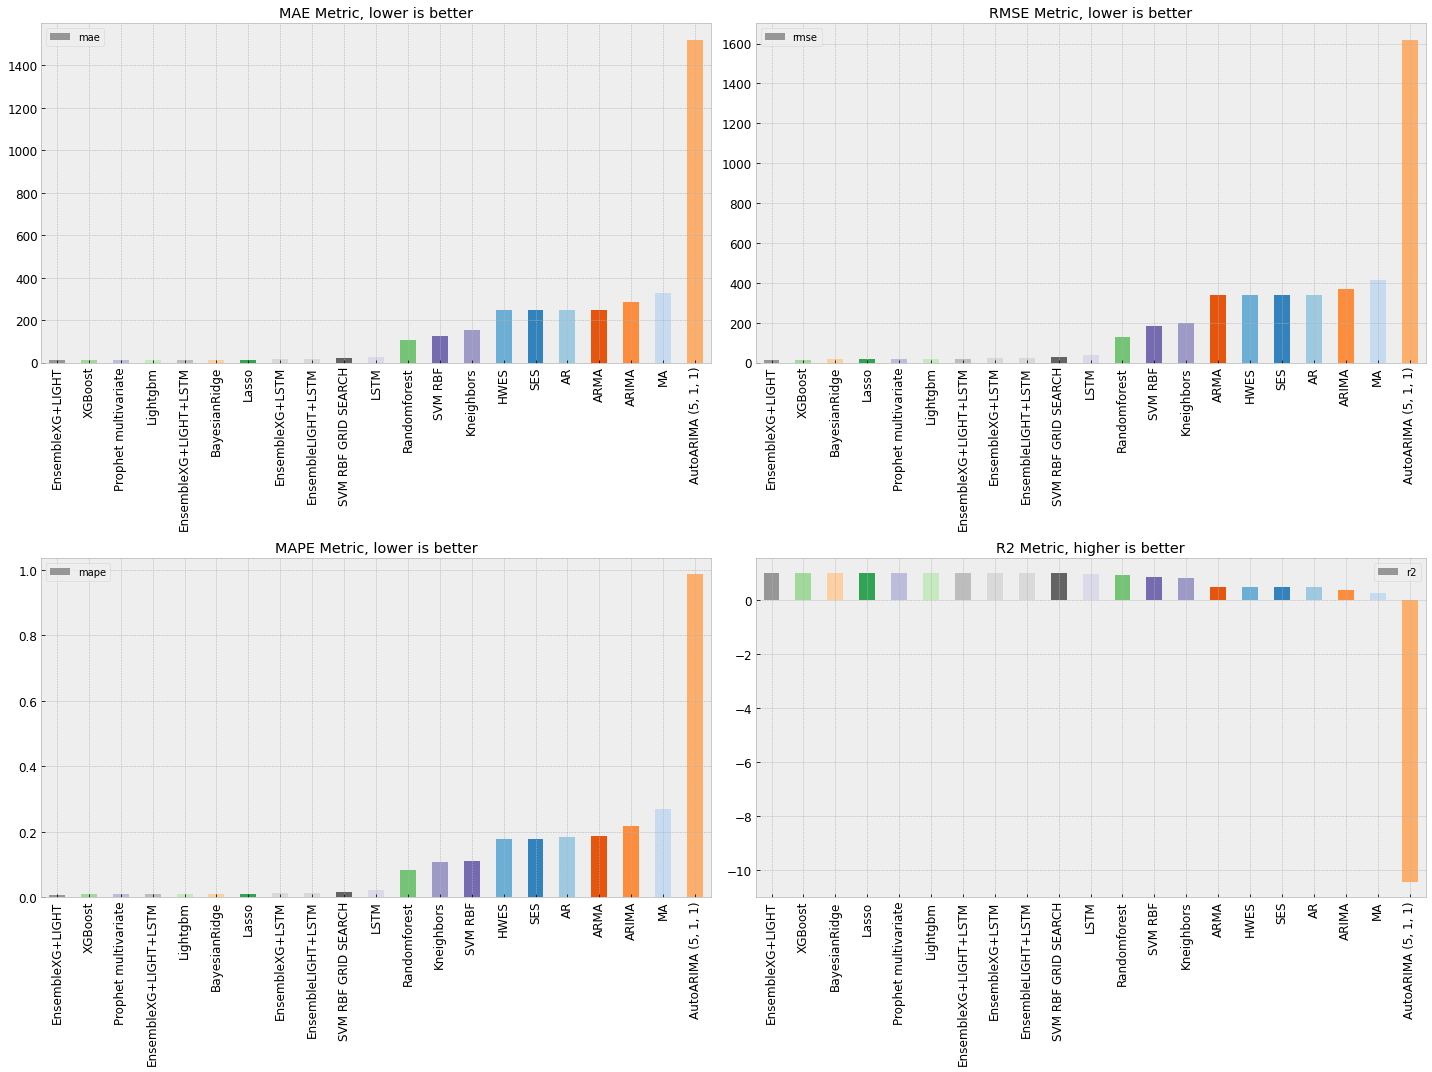

In [ ]:
bar_metrics(resultsDict)